In [2]:
%conda install openjdk -y

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install pyspark==3.2.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)


3.2.0


In [3]:
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import time
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
import datetime as DT
from datetime import date, timedelta as td

import pickle

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# 1. Functions

In [4]:
# 1. CP data
def read_cp_data(path):
    
    
    df_cp = spark.read.parquet(path)
    
    df_cp = df_cp.withColumn("PRODUCT_PART_NUMBER_IN_CP", F.col("PRODUCT_PART_NUMBER")) \
            .withColumn("ORDER_PLACED_DTTM_CP", F.col("ORDER_PLACED_DTTM"))\
			.withColumn("ORDER_PLACED_YEAR_CP", F.year(F.col("ORDER_PLACED_DTTM"))) \
			.withColumn("ORDER_PLACED_MONTH_CP", F.month(F.col("ORDER_PLACED_DTTM")))
    
    df_cp = df_cp.select("CUSTOMER_ID", "ORDER_ID", "ORDER_LINE_ID",
                               "PRODUCT_PART_NUMBER_IN_CP",
                               "ORDER_PLACED_DTTM_CP",
                               "ORDER_PLACED_YEAR_CP",
                               "ORDER_PLACED_MONTH_CP",
                               "LOCATION_CODE",
                               "ORDER_LINE_QUANTITY",
                               "ORDER_STATUS",
                               "IS_AUTO_SHIP",
                               "IB_COST","OB_COST", "COGS", "AVERAGE_PRICE", "NET_MARGIN")
    
    return df_cp

In [5]:
# 2. Complete clickstream data
def read_clickstream_data(path):
    
    df_clickstream_data = spark.read.parquet(path)

    df_clickstream_data = df_clickstream_data.withColumn("SESSION_YEAR",F.year("SESSION_EST_TIMESTAMP"))\
                               .withColumn("SESSION_MONTH",F.month("SESSION_EST_TIMESTAMP"))
    
    
    
    return df_clickstream_data

In [6]:
# 3. Complete scheduled as order data
def read_as_orders_data(path):
    
    df_as_orders_data = spark.read.parquet(path)

    df_as_orders_data = df_as_orders_data.withColumn("ORDER_PLACED_DATE",F.to_date("ORDER_PLACED_DTTM"))\
                                          .withColumn("ORDER_PLACED_YEAR",F.year("ORDER_PLACED_DTTM"))\
                                          .withColumn("ORDER_PLACED_MONTH",F.month("ORDER_PLACED_DTTM"))
    
    return df_as_orders_data

In [7]:
# 4. SKU-Month pool
def read_sku_month_candidate_data(path):
    
    pd_sku_month = pd.read_csv(path)
    
    return pd_sku_month


In [8]:
# 5. Clickstream slice
def clickstream_slice_pandas(df_data, sample_sku, sample_year, sample_month):
    
    df_slice = df_data.where((F.col("PRODUCT_PART_NUMBER")== str(sample_sku))\
                                            & (F.col("SESSION_YEAR") == sample_year) \
                                            & (F.col("SESSION_MONTH") == sample_month))
    
    pd_slice = df_slice.toPandas()
    
    return df_slice, pd_slice



In [9]:
# 6. Clickstream count summaries

def clickstream_counts_by_instock_status(pd_clickstream_data_slice):
    
    clickstream_identifier_variables = ["CUSTOMER_ID",
                              "SESSION_DATE",
                              "SESSION_EST_TIMESTAMP",
                              "PRODUCT_PART_NUMBER",
                              "STATUS",
                              "DEVICE_CATEGORY"]

    is_clickstream_counts = len(pd_clickstream_data_slice[pd_clickstream_data_slice["STATUS"] == "IN STOCK"][clickstream_identifier_variables].drop_duplicates())
    oos_clickstream_counts = len(pd_clickstream_data_slice[pd_clickstream_data_slice["STATUS"] == "OUT OF STOCK"][clickstream_identifier_variables].drop_duplicates())
    total_clickstream_counts = len(pd_clickstream_data_slice[clickstream_identifier_variables].drop_duplicates())
    
    return is_clickstream_counts, oos_clickstream_counts, total_clickstream_counts

In [10]:
# 7. Units sold summaries
def units_sold_by_as_status(df_cp_sku_month_data):
    
    non_as_units_sold = df_cp_sku_month_data.filter(F.col("IS_AUTO_SHIP") == "NON AUTO SHIP").select(F.sum("ORDER_LINE_QUANTITY")).collect()[0][0]
    as_units_sold = df_cp_sku_month_data.filter(F.col("IS_AUTO_SHIP").isin(["AUTO SHIP", "AUTO SHIP NOW"])).select(F.sum("ORDER_LINE_QUANTITY")).collect()[0][0]
    total_units_sold = df_cp_sku_month_data.select(F.sum("ORDER_LINE_QUANTITY")).collect()[0][0]

    
    return non_as_units_sold, as_units_sold, total_units_sold

In [11]:
# 8. Find clickstream cutoff dates

def find_clickstream_cutoff_dates(pd_clickstream_data_slice):
    

    
    
    # 1. Dummy variables that indicate IS and OOS
    
    pd_clickstream_data_slice["IS"] = np.where(pd_clickstream_data_slice["STATUS"] == "IN STOCK", 1, 0)
    pd_clickstream_data_slice["OOS"] = np.where(pd_clickstream_data_slice["STATUS"] == "OUT OF STOCK", 1, 0)
    
    pd_clickstream_is_oos_counts_by_date = pd_clickstream_data_slice.groupby(["SESSION_DATE"])[["IS", "OOS"]].sum().reset_index()
    pd_clickstream_is_oos_counts_by_date["IS_ADJ"] = np.where(pd_clickstream_is_oos_counts_by_date["IS"]/(pd_clickstream_is_oos_counts_by_date["IS"]+pd_clickstream_is_oos_counts_by_date["OOS"])<0.1, 0, pd_clickstream_is_oos_counts_by_date["IS"]) 
    pd_clickstream_is_oos_counts_by_date["OOS_ADJ"] = np.where(pd_clickstream_is_oos_counts_by_date["OOS"]/(pd_clickstream_is_oos_counts_by_date["IS"]+pd_clickstream_is_oos_counts_by_date["OOS"])<0.1, 0, pd_clickstream_is_oos_counts_by_date["OOS"]) 
    
    # 2. Generate status switching variable

    N = len(pd_clickstream_is_oos_counts_by_date)

    for row in range(N):

        if row == 0:

            temp = pd_clickstream_is_oos_counts_by_date.iloc[row:(row+1),].reset_index()
            is_counts = temp["IS_ADJ"][0]
            oos_counts = temp["OOS_ADJ"][0]
            
            # initialization for the first date in this monthly sample 
            if (is_counts == 0) & (oos_counts == 0):
                temp_status = "IS"
            elif (is_counts > 0) & (oos_counts == 0):
                temp_status = "IS"
            elif (is_counts == 0) & (oos_counts > 0):
                temp_status = "OOS"
            elif (is_counts > 0) & (oos_counts > 0):
                temp_status = "SWITCHING TO IS"

            temp["SWITCHING_STATUS"] = temp_status

            pd_clickstream_cutoff_point_detection = temp

        else:

            temp_t_minus_1 = pd_clickstream_cutoff_point_detection.iloc[(row-1):row,].reset_index()
            switching_status_t_minus_1 = temp_t_minus_1["SWITCHING_STATUS"][0]

            temp_t = pd_clickstream_is_oos_counts_by_date.iloc[row:(row+1),].reset_index()
            is_counts = temp_t["IS_ADJ"][0]
            oos_counts = temp_t["OOS_ADJ"][0]
            
            if (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "IS"):
                switching_status_t = "SWITCHING TO OOS"
            elif (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "OOS"):
                switching_status_t = "SWITCHING TO IS"
            elif (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO IS"):
                switching_status_t = "SWITCHING TO IS (NON-CUTOFF)"
            elif (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO IS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO IS (NON-CUTOFF)"
            elif (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS"):
                switching_status_t = "SWITCHING TO OOS (NON-CUTOFF)"
            elif (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO OOS (NON-CUTOFF)"

            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "IS"):
                switching_status_t = "IS"
            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "OOS"):
                switching_status_t = "SWITCHING TO IS"    
            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO IS"):
                switching_status_t = "IS"
            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO IS (NON-CUTOFF)"):
                switching_status_t = "IS"
            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS"):
                switching_status_t = "SWITCHING TO IS"
            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO IS"

            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "IS"):
                switching_status_t = "SWITCHING TO OOS"
            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "OOS"):
                switching_status_t = "OOS"    
            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO IS"):
                switching_status_t = "SWITCHING TO OOS"
            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO IS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO OOS"
            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS"):
                switching_status_t = "OOS"
            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS (NON-CUTOFF)"):
                switching_status_t = "OOS"

            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "IS"):
                switching_status_t = "IS"
            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "OOS"):
                switching_status_t = "OOS"    
            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO IS"):
                switching_status_t = "SWITCHING TO IS (NON-CUTOFF)"
            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO IS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO IS (NON-CUTOFF)"
            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS"):
                switching_status_t = "SWITCHING TO OOS (NON-CUTOFF)"
            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO OOS (NON-CUTOFF)"

            else:
                switching_status_t = np.nan
                print("There is NULL value in the table.")

            temp_t["SWITCHING_STATUS"] = switching_status_t
            
            pd_clickstream_cutoff_point_detection = pd_clickstream_cutoff_point_detection.append(temp_t)


    pd_clickstream_cutoff_points = pd_clickstream_cutoff_point_detection[pd_clickstream_cutoff_point_detection["SWITCHING_STATUS"].isin(["SWITCHING TO IS", "SWITCHING TO OOS"])][["SESSION_DATE","SWITCHING_STATUS"]]
    
    
    return pd_clickstream_cutoff_point_detection, pd_clickstream_cutoff_points


In [12]:
# 9. Clickstream RDD sample construction
def construct_clickstream_rdd_samples(pd_clickstream_cutoff_points, pd_clickstream_cutoff_point_detection, pd_clickstream_data_slice, sufficiency_ratio, initial_window_length, first_layer_index, df_cp):
    
    
    print("==========CONSTRUCTING CLICKSTREAM RDD SAMPLE FOR " + first_layer_index + " ==========")
    
    
    start_time_00 = time.time()
    
    clickstream_rdd_sample_collection_temp = {}
    
    # 1. RDD sample generation
    for k in range(len(pd_clickstream_cutoff_points)):
        
        window_length = initial_window_length

        cutoff_point = pd_clickstream_cutoff_points.iloc[k,]["SESSION_DATE"]

        cutoff_point_name = pd_clickstream_cutoff_points.iloc[k,]["SWITCHING_STATUS"]

        # Check T days prior to the cutoff date and T days after the cutoff date
        while window_length > 0:

            # Window start date
            window_left_end = max(cutoff_point - DT.timedelta(days=window_length), min(pd_clickstream_cutoff_point_detection["SESSION_DATE"]))
            # Window end date
            window_right_end = min(cutoff_point + DT.timedelta(days=(window_length+1)), max(pd_clickstream_cutoff_point_detection["SESSION_DATE"])+ DT.timedelta(days=1))

            pd_cutoff_point_detection_rdd_sample_temp = pd_clickstream_cutoff_point_detection[(pd_clickstream_cutoff_point_detection["SESSION_DATE"] >= window_left_end) & (pd_clickstream_cutoff_point_detection["SESSION_DATE"] < window_right_end) ]

            # [1] We want to make sure this sample only has the cutoff point that is under inspection
            if np.sum(pd_cutoff_point_detection_rdd_sample_temp["SWITCHING_STATUS"].isin(["SWITCHING TO IS", "SWITCHING TO OOS"]))>1:
                window_length = window_length - 1
                if window_length == 0:
                    print("THIS IS THE SHORTEST RDD SAMPLE OF " + str(cutoff_point) + " YET IT IS STILL NOT CLEAN")
                continue
            else:
                print("FOUND A CLEAN RDD SAMPLE FOR " + str(cutoff_point) + " WITH WINDOW LENGTH " + str(window_length))
                print("CHECKING DATA SUFFICIENCY")

            # [1] Clickstream RDD horizon
            clickstream_rdd_sample_temp = pd_clickstream_data_slice[ (pd_clickstream_data_slice["SESSION_DATE"]>=window_left_end) & (pd_clickstream_data_slice["SESSION_DATE"]< window_right_end)]

            # [2] Remove duplicate clickstream data points   
            clickstream_identifier_variables = ["CUSTOMER_ID", "SESSION_EST_TIMESTAMP",
                            "PRODUCT_PART_NUMBER", 
                            "STATUS", 
                            "DEVICE_CATEGORY",
                            "SESSION_DATE", "SESSION_YEAR", "SESSION_MONTH"]
            clickstream_rdd_sample_cleaned = clickstream_rdd_sample_temp[clickstream_identifier_variables].drop_duplicates()

            # [3] Ensure at least 50% of days on both sides of the cutoff point need to have data 
            # Summarize daily data points
            clickstream_counts_distribution_across_days = clickstream_rdd_sample_cleaned.groupby(["SESSION_DATE"])["CUSTOMER_ID"].count().reset_index()

            if (clickstream_counts_distribution_across_days[clickstream_counts_distribution_across_days["SESSION_DATE"] < cutoff_point]["SESSION_DATE"].nunique() >= window_length*sufficiency_ratio) & \
             (clickstream_counts_distribution_across_days[clickstream_counts_distribution_across_days["SESSION_DATE"] > cutoff_point]["SESSION_DATE"].nunique() >= window_length*sufficiency_ratio):
                print("WE FOUND SUFFICIENT DATA FOR " + str(cutoff_point) + " WITH WINDOW LENGTH " + str(window_length))
                print("LEFT SIDE HAS " + str(clickstream_counts_distribution_across_days[clickstream_counts_distribution_across_days["SESSION_DATE"] < cutoff_point]["SESSION_DATE"].nunique()) + " DAYS OF DATA")
                print("RIGHT SIDE HAS " + str(clickstream_counts_distribution_across_days[clickstream_counts_distribution_across_days["SESSION_DATE"] > cutoff_point]["SESSION_DATE"].nunique()) + " DAYS OF DATA")
                print("THIS RDD SAMPLE IS COLLECTED FOR REGRESSION AND ANALYSES")
                break

            else:
                window_length = window_length - 1
                if window_length == 0:   
                    print("THIS IS THE SHORTEST RDD SAMPLE OF " + str(cutoff_point) + " YET IT DOES NOT HAVE SUFFICIENT DATA")
                continue

        if window_length == 0:
            print("UNFORTUNATELY, WE CANNOT FIND AN IDEAL RDD SAMPLE FOR CUTOFF POINT: " + str(cutoff_point))
            continue

        else:
            print("WE HAVE FOUND THE RDD SAMPLE FOR REGRESSION FOR CUTOFF POINT: " + str(cutoff_point))
            print("THE LEFT END DATE IS: " + str(window_left_end))
            print("THE RIGHT END DATE IS: " + str(window_right_end))

            # 2. Feature Engineering

            # [1] The precise timestamp of the cutoff point
            
            # We make the following update: if the status switches from OOS to IS then we use the first IS timestamp within the cutoff date as the cutoff timestamp. Similar for IS -> OOS.  
            
            clickstream_rdd_sample_on_cutoff_date = clickstream_rdd_sample_cleaned[clickstream_rdd_sample_cleaned["SESSION_DATE"] == cutoff_point]
            
            clickstream_rdd_sample_on_cutoff_date["STATUS_RANK"] = clickstream_rdd_sample_on_cutoff_date.groupby("STATUS")["SESSION_EST_TIMESTAMP"].rank(method = "dense", ascending = True).astype(int)

            if cutoff_point_name == "SWITCHING TO IS":

                cutoff_point_timestamp = clickstream_rdd_sample_on_cutoff_date[clickstream_rdd_sample_on_cutoff_date["STATUS_RANK"]==1][clickstream_rdd_sample_on_cutoff_date["STATUS"] == "IN STOCK"].reset_index().iloc[0]["SESSION_EST_TIMESTAMP"]

            else:

                cutoff_point_timestamp = clickstream_rdd_sample_on_cutoff_date[clickstream_rdd_sample_on_cutoff_date["STATUS_RANK"]==1][clickstream_rdd_sample_on_cutoff_date["STATUS"] == "OUT OF STOCK"].reset_index().iloc[0]["SESSION_EST_TIMESTAMP"]

                
            # [2] Treatment variable    
            
            clickstream_rdd_sample_cleaned["TREATMENT_VARIABLE"] = np.where(clickstream_rdd_sample_cleaned["STATUS"] == "IN STOCK", 1, 0)


            # [3] Generate the hour difference between the timestamp and the cutoff point
            
            # We make the following update: We are going to drop data points that are "not consistent with RDD design"
           
            clickstream_rdd_sample_cleaned["RUNNING_VARIABLE"] = (clickstream_rdd_sample_cleaned["SESSION_EST_TIMESTAMP"] - cutoff_point_timestamp).dt.total_seconds()/3600

            if cutoff_point_name == "SWITCHING TO IS":

                clickstream_rdd_sample_cleaned["DROP_INDICATOR"] = np.where( ((clickstream_rdd_sample_cleaned["TREATMENT_VARIABLE"] == 1) & (clickstream_rdd_sample_cleaned["RUNNING_VARIABLE"] < 0)) \
                                                                              | ((clickstream_rdd_sample_cleaned["TREATMENT_VARIABLE"] == 0) & (clickstream_rdd_sample_cleaned["RUNNING_VARIABLE"] >= 0)), 1, 0)
            
                print("BEFORE DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: " + str(len(clickstream_rdd_sample_cleaned)))
                
                clickstream_rdd_sample_cleaned = clickstream_rdd_sample_cleaned[clickstream_rdd_sample_cleaned["DROP_INDICATOR"]==0]
                
                print("AFTER DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: " + str(len(clickstream_rdd_sample_cleaned)))
                
            else:
                
                clickstream_rdd_sample_cleaned["DROP_INDICATOR"] = np.where( ((clickstream_rdd_sample_cleaned["TREATMENT_VARIABLE"] == 1) & (clickstream_rdd_sample_cleaned["RUNNING_VARIABLE"] >= 0)) \
                                                                              | ((clickstream_rdd_sample_cleaned["TREATMENT_VARIABLE"] == 0) & (clickstream_rdd_sample_cleaned["RUNNING_VARIABLE"] < 0)), 1, 0)

                print("BEFORE DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: " + str(len(clickstream_rdd_sample_cleaned)))
                
                clickstream_rdd_sample_cleaned = clickstream_rdd_sample_cleaned[clickstream_rdd_sample_cleaned["DROP_INDICATOR"]==0]
                
                print("AFTER DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: " + str(len(clickstream_rdd_sample_cleaned)))
            
            # [4] Outcome Variable Construction

            customer_id_list_in_clickstream_rdd_sample = clickstream_rdd_sample_cleaned[["CUSTOMER_ID"]].drop_duplicates()["CUSTOMER_ID"].to_list()

            # Add filtering variables
            clickstream_rdd_sample_cleaned["SESSION_EST_TIMESTAMP_UB"] = clickstream_rdd_sample_cleaned["SESSION_EST_TIMESTAMP"] + pd.Timedelta(hours=24)
            clickstream_rdd_sample_cleaned["SESSION_EST_TIMESTAMP_END"] = clickstream_rdd_sample_cleaned["SESSION_EST_TIMESTAMP"] + pd.Timedelta(hours=24*365)

            # Max timestamp possible for CP calculation
            max_timestamp = np.max(clickstream_rdd_sample_cleaned["SESSION_EST_TIMESTAMP_END"])

            # Min timestamp possible for CP calculation
            min_timestamp = np.min(clickstream_rdd_sample_cleaned["SESSION_EST_TIMESTAMP"])

            # Focus on customers in clickstream data & Focus on time period that is relevant
            df_cp_clickstream = df_cp.filter( (F.col("CUSTOMER_ID").isin(customer_id_list_in_clickstream_rdd_sample)) & \
                                            (F.col("ORDER_PLACED_DTTM") >= min_timestamp) & \
                                            (F.col("ORDER_PLACED_DTTM") <= max_timestamp) )

            df_cp_clickstream = df_cp_clickstream.withColumn("NET_MARGIN_V2",  F.col("AVERAGE_PRICE")-F.col("IB_COST")-F.col("OB_COST")-F.col("COGS"))

            df_cp_clickstream.persist()

            # Transform the small cp data into pandas dataframe

            print("==========Converting CP data into Pandas data frame==========")
            start_time = time.time()
            pd_cp_clickstream = df_cp_clickstream.toPandas()
            pd_cp_clickstream["ORDER_LINE_QUANTITY"] = pd_cp_clickstream["ORDER_LINE_QUANTITY"].astype(float)
            print("--- %s seconds ---" % (time.time() - start_time))

            # Columns we need from clickstream data
            clickstream_relevant_columns = ["CUSTOMER_ID", "SESSION_EST_TIMESTAMP", "SESSION_EST_TIMESTAMP_UB", "SESSION_EST_TIMESTAMP_END",
                            "PRODUCT_PART_NUMBER", 
                            "STATUS", 
                            "DEVICE_CATEGORY", 
                            "SESSION_YEAR", "SESSION_MONTH", 
                            "RUNNING_VARIABLE", "TREATMENT_VARIABLE"]
            clickstream_rdd_sample_cleaned_adj = clickstream_rdd_sample_cleaned[clickstream_relevant_columns]

            start_time_0 = time.time()

            # alternative way
            for row in range(len(clickstream_rdd_sample_cleaned_adj)):

                # print("==========NOW GENERATING CP FOR DATA POINT: " + str(row) + " ==========")

                # start_time = time.time()

                # Loop through each clickstream data point

                clickstream_dp = clickstream_rdd_sample_cleaned_adj.iloc[row:(row+1),:].reset_index()

                # info needed to be added to CP data
                customer_id = clickstream_dp["CUSTOMER_ID"][0]
                product_part_number = clickstream_dp["PRODUCT_PART_NUMBER"][0]
                timestamp_lb = clickstream_dp["SESSION_EST_TIMESTAMP"][0]
                timestamp_ub = clickstream_dp["SESSION_EST_TIMESTAMP_UB"][0]
                timestamp_end = clickstream_dp["SESSION_EST_TIMESTAMP_END"][0]
                device_type = clickstream_dp["DEVICE_CATEGORY"][0]
                instock_status = clickstream_dp["STATUS"][0]
                running_variable = clickstream_dp["RUNNING_VARIABLE"][0]
                treatment_variable = clickstream_dp["TREATMENT_VARIABLE"][0]

                # get CP data that corresponds to the customer id of the clickstream dp
                pd_cp_clickstream_dp = pd_cp_clickstream[pd_cp_clickstream["CUSTOMER_ID"] == customer_id]

                # add the info from the clickstream dp into CP data
                pd_cp_clickstream_dp["PRODUCT_PART_NUMBER"] = product_part_number
                pd_cp_clickstream_dp["SESSION_EST_TIMESTAMP"] = timestamp_lb
                pd_cp_clickstream_dp["SESSION_EST_TIMESTAMP_UB"] = timestamp_ub
                pd_cp_clickstream_dp["SESSION_EST_TIMESTAMP_END"] = timestamp_end
                pd_cp_clickstream_dp["DEVICE_CATEGORY"] = device_type
                pd_cp_clickstream_dp["STATUS"] = instock_status
                pd_cp_clickstream_dp["RUNNING_VARIABLE"] = running_variable
                pd_cp_clickstream_dp["TREATMENT_VARIABLE"] = treatment_variable

                # if len(pd_cp_clickstream_dp) == 0:

                #    print("THIS DATA POINT HAS NO CP RECORD")

                # else:

                #    print("THIS DATA POINT HAS CP RECORD: " + str(len(pd_cp_clickstream_dp)))


                pd_cp_clickstream_dp["CP_INCLUDED"] = np.where(

                    ((pd_cp_clickstream_dp['PRODUCT_PART_NUMBER_IN_CP'] != pd_cp_clickstream_dp['PRODUCT_PART_NUMBER']) & (pd_cp_clickstream_dp['ORDER_PLACED_DTTM_CP'] >= pd_cp_clickstream_dp['SESSION_EST_TIMESTAMP']) & (pd_cp_clickstream_dp['ORDER_PLACED_DTTM_CP'] < pd_cp_clickstream_dp['SESSION_EST_TIMESTAMP_UB']))\
                    | \

                    ((pd_cp_clickstream_dp['ORDER_PLACED_DTTM_CP'] >= pd_cp_clickstream_dp['SESSION_EST_TIMESTAMP_UB']) & (pd_cp_clickstream_dp['ORDER_PLACED_DTTM_CP'] < pd_cp_clickstream_dp['SESSION_EST_TIMESTAMP_END']))

                    , 1, 0)
                
                
                pd_cp_clickstream_dp["CP_INCLUDED_V2"] = np.where(

                (pd_cp_clickstream_dp['PRODUCT_PART_NUMBER_IN_CP'] != pd_cp_clickstream_dp['PRODUCT_PART_NUMBER']) \
                 & ((pd_cp_clickstream_dp['ORDER_PLACED_DTTM_CP'] >= pd_cp_clickstream_dp['SESSION_EST_TIMESTAMP']) \
                    & (pd_cp_clickstream_dp['ORDER_PLACED_DTTM_CP'] < pd_cp_clickstream_dp['SESSION_EST_TIMESTAMP_END']))

                , 1, 0)

                pd_cp_clickstream_dp["CP"] = pd_cp_clickstream_dp["CP_INCLUDED"] * pd_cp_clickstream_dp["NET_MARGIN"] * pd_cp_clickstream_dp["ORDER_LINE_QUANTITY"]
                pd_cp_clickstream_dp["CP_V2"] = pd_cp_clickstream_dp["CP_INCLUDED"] * pd_cp_clickstream_dp["NET_MARGIN_V2"] * pd_cp_clickstream_dp["ORDER_LINE_QUANTITY"]

                pd_cp_clickstream_dp["CP_V3"] = pd_cp_clickstream_dp["CP_INCLUDED_V2"] * pd_cp_clickstream_dp["NET_MARGIN"] * pd_cp_clickstream_dp["ORDER_LINE_QUANTITY"]
                pd_cp_clickstream_dp["CP_V4"] = pd_cp_clickstream_dp["CP_INCLUDED_V2"] * pd_cp_clickstream_dp["NET_MARGIN_V2"] * pd_cp_clickstream_dp["ORDER_LINE_QUANTITY"]

                
                groupVars = ["PRODUCT_PART_NUMBER", "CUSTOMER_ID", 
                             "SESSION_EST_TIMESTAMP", "SESSION_EST_TIMESTAMP_UB", "SESSION_EST_TIMESTAMP_END", 
                             "STATUS", 
                             "DEVICE_CATEGORY",
                             "RUNNING_VARIABLE", "TREATMENT_VARIABLE"]

                pd_agg_cp_clickstream_dp = pd_cp_clickstream_dp.groupby(groupVars)[["CP","CP_V2","CP_V3","CP_V4"]].sum().reset_index()

                if row == 0:

                    pd_clickstream_cp_outcome =  pd_agg_cp_clickstream_dp

                else:

                    pd_clickstream_cp_outcome = pd_clickstream_cp_outcome.append(pd_agg_cp_clickstream_dp)

                # print("==========GENERATION IS COMPLETED FOR DATA POINT: " + str(row) + " ==========")
                # print("--- %s seconds ---" % (time.time() - start_time))


            print("--- TOTAL --- %s seconds ---" % (time.time() - start_time_0))


            clickstream_rdd_sample_cleaned["CUSTOMER_ID"] = clickstream_rdd_sample_cleaned["CUSTOMER_ID"].astype(str)
            pd_clickstream_cp_outcome["CUSTOMER_ID"] = pd_clickstream_cp_outcome["CUSTOMER_ID"].astype(str)

            rdd_sample = pd.merge(clickstream_rdd_sample_cleaned, pd_clickstream_cp_outcome, on = groupVars, how = "left")

            second_layer_index = str(cutoff_point) + "_" + str(cutoff_point_name) + "_" + str(window_length)

            print("CP NULL VALUE COUNTS FOR " + first_layer_index + "_" + second_layer_index + " IS " + str(sum(rdd_sample["CP"].isna())/len(rdd_sample)))
            print("CP_V2 NULL VALUE COUNTS FOR " + first_layer_index + "_" + second_layer_index + " IS " + str(sum(rdd_sample["CP_V2"].isna())/len(rdd_sample)))
            print("CP_V3 NULL VALUE COUNTS FOR " + first_layer_index + "_" + second_layer_index + " IS " + str(sum(rdd_sample["CP_V3"].isna())/len(rdd_sample)))
            print("CP_V4 NULL VALUE COUNTS FOR " + first_layer_index + "_" + second_layer_index + " IS " + str(sum(rdd_sample["CP_V4"].isna())/len(rdd_sample)))

            rdd_sample = rdd_sample.fillna({"CP":0,
                                           "CP_V2":0,
                                            "CP_V3":0,
                                            "CP_V4":0})

            clickstream_rdd_sample_collection_temp[second_layer_index] = rdd_sample
        
        
    print("--- TOTAL RUNTIME FOR RDD CONSTRUCTION OF" + first_layer_index + "IS " +  str(time.time() - start_time_00))
        
    return clickstream_rdd_sample_collection_temp

In [13]:
# 10. Add kernel weights to RDD regression

def kernel(R, h, a1, a2):
    indicator = (np.abs(R) <= h).astype(float)
    return (indicator * (1 - np.abs(R)/h) / a1) ** a2


In [14]:
# 11. Clickstream RDD
def clickstream_rdd_modeling(clickstream_rdd_sample_collection, first_layer_index, cp_variable, K, regression_type, h, a1, a2, bootstrapping_method, boostramp_sample_size):

    clickstream_rdd_estimate_collection = {}
    
    print("========== RUNNING CLICKSTREAM RDD FOR " + first_layer_index + " ==========")
    
    start_time_00 = time.time()
    
    if regression_type == "SEPARATE_UNWEIGHTED":

        for sample_index, pd_rdd_sample in clickstream_rdd_sample_collection.items():
            print("========== NOW RUNNING SEPARATE_UNWEIGHTED REGRESSION FOR SAMPLE: " + str(sample_index) + "==========")

            print("DATA POINTS: " + str(len(pd_rdd_sample)))

            print("========== STEP 1: FURTHER FEATURE ENGINEERING: REMOVE NULL DATA POINTS ==========")  
            pd_rdd_sample = pd_rdd_sample[~pd_rdd_sample[cp_variable].isna()]
            pd_rdd_sample

            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 2: FURTHER FEATURE ENGINEERING: ADD NON-LINEARITY==========")
            pd_rdd_sample["RUNNING_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE"] 
            pd_rdd_sample["RUNNING_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE"] * pd_rdd_sample["RUNNING_VARIABLE"]
            pd_rdd_sample["RUNNING_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["RUNNING_VARIABLE"]
            pd_rdd_sample["RUNNING_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["RUNNING_VARIABLE"]

            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE_1"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_4"] * pd_rdd_sample["TREATMENT_VARIABLE"]

            print("========== STEP 3: FURTHER FEATURE ENGINEERING: WINDOW LENGTH ADJUSTMENT==========")   
            rdd_window_lb = min(pd_rdd_sample["RUNNING_VARIABLE"])
            rdd_window_ub = max(pd_rdd_sample["RUNNING_VARIABLE"])

            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample["RUNNING_VARIABLE"] >= rdd_window_lb) & (pd_rdd_sample["RUNNING_VARIABLE"] <= rdd_window_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 4: FILTERING OUT EXTREME CP VALUES==========")   
            lb_perc = .025
            ub_perc = .975
            perc_lb = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[lb_perc]
            perc_ub = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[ub_perc]
            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample[cp_variable] >= perc_lb) & (pd_rdd_sample[cp_variable] <= perc_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 5: VISUALIZATION==========")
            if sample_index.split("_")[1] == "SWITCHING TO IS":

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()

            else:

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()        

            print("========== STEP 6: REGRESSION==========")

            # ORDER OF POLYNOMIAL
            K = 1

            var_list = ["TREATMENT_VARIABLE"] + ["RUNNING_VARIABLE_" + str(n) for n in np.arange(1,K+1)] + ["RUNNING_x_TREATMENT_VARIABLE_" + str(n) for n in np.arange(1,K+1)]

            if bootstrapping_method == False:

                X = pd_rdd_sample[var_list]
                X = sm.add_constant(X)

                Y = pd_rdd_sample[[cp_variable]]


                results = sm.OLS(Y, X).fit()

                print(results.summary())

                rdd_estimate_value = results.params["TREATMENT_VARIABLE"]
                rdd_estimate_std_err = results.bse["TREATMENT_VARIABLE"]

                print("(CLICKSTREAM) THE ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(CLICKSTREAM) THE STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))

            else:

                estimate_list = []
                for s in range(boostramp_sample_size):
                    pd_rdd_sample_resampled = pd_rdd_sample.sample(n = len(pd_rdd_sample), replace = True)
                    
                    X = pd_rdd_sample_resampled[var_list]
                    X = sm.add_constant(X)
                    
                    Y = pd_rdd_sample_resampled[[cp_variable]]
                    
                    results = sm.OLS(Y, X).fit()
                    
                    estimate_list = estimate_list + [results.params["TREATMENT_VARIABLE"]]
                    
                plt.hist(np.array(estimate_list))
                plt.show()
                
                rdd_estimate_value = np.mean(np.array(estimate_list))
                rdd_estimate_std_err = np.std(np.array(estimate_list))
                
                print("(CLICKSTREAM) THE BOOSTRAPPED ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(CLICKSTREAM) THE BOOSTRAPPED STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))


            clickstream_rdd_estimate_collection[sample_index] = {}
            clickstream_rdd_estimate_collection[sample_index]["Estimate"] = rdd_estimate_value
            clickstream_rdd_estimate_collection[sample_index]["StdError"] = rdd_estimate_std_err


    elif regression_type == "SEPARATE_WEIGHTED":

        for sample_index, pd_rdd_sample in clickstream_rdd_sample_collection.items():
            print("========== NOW RUNNING SEPARATE_WEIGHTED REGRESSION FOR SAMPLE: " + str(sample_index) + "==========")

            print("DATA POINTS: " + str(len(pd_rdd_sample)))

            print("========== STEP 1: FURTHER FEATURE ENGINEERING: REMOVE NULL DATA POINTS ==========")  
            pd_rdd_sample = pd_rdd_sample[~pd_rdd_sample[cp_variable].isna()]
            pd_rdd_sample

            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 2: FURTHER FEATURE ENGINEERING: ADD NON-LINEARITY==========")
            pd_rdd_sample["RUNNING_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE"] 
            pd_rdd_sample["RUNNING_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE"] * pd_rdd_sample["RUNNING_VARIABLE"]
            pd_rdd_sample["RUNNING_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["RUNNING_VARIABLE"]
            pd_rdd_sample["RUNNING_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["RUNNING_VARIABLE"]

            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE_1"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_4"] * pd_rdd_sample["TREATMENT_VARIABLE"]

            print("========== STEP 3: FURTHER FEATURE ENGINEERING: WINDOW LENGTH ADJUSTMENT==========")   
            rdd_window_lb = min(pd_rdd_sample["RUNNING_VARIABLE"])
            rdd_window_ub = max(pd_rdd_sample["RUNNING_VARIABLE"])

            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample["RUNNING_VARIABLE"] >= rdd_window_lb) & (pd_rdd_sample["RUNNING_VARIABLE"] <= rdd_window_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 4: FILTERING OUT EXTREME CP VALUES==========")   
            lb_perc = .025
            ub_perc = .975
            perc_lb = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[lb_perc]
            perc_ub = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[ub_perc]
            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample[cp_variable] >= perc_lb) & (pd_rdd_sample[cp_variable] <= perc_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 5: VISUALIZATION==========")
            if sample_index.split("_")[1] == "SWITCHING TO IS":

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()

            else:

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()        

            print("========== STEP 6: REGRESSION==========")

            # ORDER OF POLYNOMIAL

            var_list = ["TREATMENT_VARIABLE"] + ["RUNNING_VARIABLE_" + str(n) for n in np.arange(1,K+1)] + ["RUNNING_x_TREATMENT_VARIABLE_" + str(n) for n in np.arange(1,K+1)]


            if bootstrapping_method == False:

                X = pd_rdd_sample[var_list]
                X = sm.add_constant(X)

                Y = pd_rdd_sample[[cp_variable]]

                results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()

                print(results.summary())

                rdd_estimate_value = results.params["TREATMENT_VARIABLE"]
                rdd_estimate_std_err = results.bse["TREATMENT_VARIABLE"]

                print("(CLICKSTREAM) THE ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(CLICKSTREAM) THE STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))

            else:
                
                estimate_list = []
                
                for s in range(boostramp_sample_size):
                    
                    pd_rdd_sample_resampled = pd_rdd_sample.sample(n = len(pd_rdd_sample), replace = True)
                    
                    X = pd_rdd_sample_resampled[var_list]
                    X = sm.add_constant(X)

                    Y = pd_rdd_sample_resampled[[cp_variable]]
                    results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()
                    estimate_list = estimate_list + [results.params["TREATMENT_VARIABLE"]]
                
                plt.hist(np.array(estimate_list))
                plt.show()
                
                rdd_estimate_value = np.mean(np.array(estimate_list))
                rdd_estimate_std_err = np.std(np.array(estimate_list))
                
                print("(CLICKSTREAM) THE BOOSTRAPPED ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(CLICKSTREAM) THE BOOSTRAPPED STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))


            clickstream_rdd_estimate_collection[sample_index] = {}
            clickstream_rdd_estimate_collection[sample_index]["Estimate"] = rdd_estimate_value
            clickstream_rdd_estimate_collection[sample_index]["StdError"] = rdd_estimate_std_err
		
    elif regression_type == "JOINT_WEIGHTED":

        index = 1
        
        for sample_index_temp, pd_rdd_sample_temp in clickstream_rdd_sample_collection.items():
            
            print("========== NOW RUNNING JOINT_WEIGHTED REGRESSION ==========")
            print("FOR SAMPLE " + sample_index_temp + ", DATA POINTS: " + str(len(pd_rdd_sample_temp)))

            pd_rdd_sample_temp["SAMPLE_INDEX"] = index

            if index == 1:

                pd_rdd_sample = pd_rdd_sample_temp
                sample_index = sample_index_temp

            else:

                pd_rdd_sample = pd_rdd_sample.append(pd_rdd_sample_temp)
                sample_index = sample_index_temp

            index = index + 1
            
            print("JOINT SAMPLE HAS DATA POINTS: " + str(len(pd_rdd_sample)))


        print("========== STEP 1: FURTHER FEATURE ENGINEERING: REMOVE NULL DATA POINTS ==========")  
        pd_rdd_sample = pd_rdd_sample[~pd_rdd_sample[cp_variable].isna()]
        pd_rdd_sample

        print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

        print("========== STEP 2: FURTHER FEATURE ENGINEERING: ADD NON-LINEARITY==========")
        pd_rdd_sample["RUNNING_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE"] 
        pd_rdd_sample["RUNNING_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE"] * pd_rdd_sample["RUNNING_VARIABLE"]
        pd_rdd_sample["RUNNING_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["RUNNING_VARIABLE"]
        pd_rdd_sample["RUNNING_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["RUNNING_VARIABLE"]

        pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE_1"] * pd_rdd_sample["TREATMENT_VARIABLE"]
        pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["TREATMENT_VARIABLE"]
        pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["TREATMENT_VARIABLE"]
        pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_4"] * pd_rdd_sample["TREATMENT_VARIABLE"]



        if np.max(pd_rdd_sample["SAMPLE_INDEX"]) == 1:
            
            print("NO NEED TO JOIN AND PROCEED AS SEPARATE REGRESSION")

            print("========== STEP 3: FURTHER FEATURE ENGINEERING: WINDOW LENGTH ADJUSTMENT==========") 
            
            rdd_window_lb = min(pd_rdd_sample["RUNNING_VARIABLE"])
            rdd_window_ub = max(pd_rdd_sample["RUNNING_VARIABLE"])
            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample["RUNNING_VARIABLE"] >= rdd_window_lb) & (pd_rdd_sample["RUNNING_VARIABLE"] <= rdd_window_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 4: FILTERING OUT EXTREME CP VALUES==========")   
            lb_perc = .025
            ub_perc = .975
            perc_lb = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[lb_perc]
            perc_ub = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[ub_perc]
            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample[cp_variable] >= perc_lb) & (pd_rdd_sample[cp_variable] <= perc_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 5: VISUALIZATION==========")
            if sample_index.split("_")[1] == "SWITCHING TO IS":

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()

            else:

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()        

            print("========== STEP 6: REGRESSION==========")

            # ORDER OF POLYNOMIAL

            var_list = ["TREATMENT_VARIABLE"] + ["RUNNING_VARIABLE_" + str(n) for n in np.arange(1,K+1)] + ["RUNNING_x_TREATMENT_VARIABLE_" + str(n) for n in np.arange(1,K+1)]

            if bootstrapping_method == False:

                X = pd_rdd_sample[var_list]
                X = sm.add_constant(X)

                Y = pd_rdd_sample[[cp_variable]]

                results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()

                print(results.summary())

                rdd_estimate_value = results.params["TREATMENT_VARIABLE"]
                rdd_estimate_std_err = results.bse["TREATMENT_VARIABLE"]

                print("(CLICKSTREAM) THE ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(CLICKSTREAM) THE STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))

            else:

                estimate_list = []
                for s in range(boostramp_sample_size):
                    
                    pd_rdd_sample_resampled = pd_rdd_sample.sample(n = len(pd_rdd_sample), replace = True)
                    
                    X = pd_rdd_sample_resampled[var_list]
                    X = sm.add_constant(X)

                    Y = pd_rdd_sample_resampled[[cp_variable]]
                    
                    results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()
                    estimate_list = estimate_list + [results.params["TREATMENT_VARIABLE"]]
                
                plt.hist(np.array(estimate_list))
                plt.show()
                
                rdd_estimate_value = np.mean(np.array(estimate_list))
                rdd_estimate_std_err = np.std(np.array(estimate_list))
                
                print("(CLICKSTREAM) THE BOOSTRAPPED ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(CLICKSTREAM) THE BOOSTRAPPED STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))


        else:
            
            index_var_name_list = []
            
            for m in np.arange(2, np.max(pd_rdd_sample["SAMPLE_INDEX"])+1):
                
                index_var_name = "SAMPLE_INDEX" + "_" + str(m)
                pd_rdd_sample[index_var_name] = np.where(pd_rdd_sample["SAMPLE_INDEX"] == m, 1, 0)
                index_var_name_list = index_var_name_list + [index_var_name]

            vars_for_interaction_with_sample_index = ["RUNNING_VARIABLE_1", "RUNNING_VARIABLE_2", "RUNNING_VARIABLE_3", "RUNNING_VARIABLE_4",
                                                      "RUNNING_x_TREATMENT_VARIABLE_1", 
                                                      "RUNNING_x_TREATMENT_VARIABLE_2", 
                                                      "RUNNING_x_TREATMENT_VARIABLE_3", 
                                                      "RUNNING_x_TREATMENT_VARIABLE_4"]
            
            interaction_var_name_list = []
            
            for m1 in index_var_name_list:
                for m2 in vars_for_interaction_with_sample_index:
                    
                    interaction_var_name = m2 + "_" + m1
                    pd_rdd_sample[interaction_var_name] = pd_rdd_sample[m1] * pd_rdd_sample[m2]
                    interaction_var_name_list = interaction_var_name_list + [interaction_var_name]


            print("========== STEP 3: FURTHER FEATURE ENGINEERING: WINDOW LENGTH ADJUSTMENT==========")   
            rdd_window_lb = min(pd_rdd_sample["RUNNING_VARIABLE"])
            rdd_window_ub = max(pd_rdd_sample["RUNNING_VARIABLE"])

            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample["RUNNING_VARIABLE"] >= rdd_window_lb) & (pd_rdd_sample["RUNNING_VARIABLE"] <= rdd_window_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 4: FILTERING OUT EXTREME CP VALUES==========")   
            lb_perc = .025
            ub_perc = .975
            perc_lb = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[lb_perc]
            perc_ub = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[ub_perc]
            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample[cp_variable] >= perc_lb) & (pd_rdd_sample[cp_variable] <= perc_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 5: REGRESSION==========")

            # ORDER OF POLYNOMIAL

            var_list = ["TREATMENT_VARIABLE"] + ["RUNNING_VARIABLE_" + str(n) for n in np.arange(1,K+1)] \
            + ["RUNNING_x_TREATMENT_VARIABLE_" + str(n) for n in np.arange(1,K+1)] \
            + ["RUNNING_VARIABLE_" + str(n1)  + "_" + "SAMPLE_INDEX_" + str(n2) for n1 in np.arange(1,K+1) for n2 in np.arange(2, np.max(pd_rdd_sample["SAMPLE_INDEX"])+1)] \
            + ["RUNNING_x_TREATMENT_VARIABLE_" + str(n1)  + "_" + "SAMPLE_INDEX_" + str(n2) for n1 in np.arange(1,K+1) for n2 in np.arange(2, np.max(pd_rdd_sample["SAMPLE_INDEX"])+1)]

            if bootstrapping_method == False:

                X = pd_rdd_sample[var_list]
                X = sm.add_constant(X)

                Y = pd_rdd_sample[[cp_variable]]

                results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()

                print(results.summary())

                rdd_estimate_value = results.params["TREATMENT_VARIABLE"]
                rdd_estimate_std_err = results.bse["TREATMENT_VARIABLE"]

                print("(CLICKSTREAM) THE ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(CLICKSTREAM) THE STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))

            else:
                
                estimate_list = []
                
                for s in range(boostramp_sample_size):
                    
                    pd_rdd_sample_resampled = pd_rdd_sample.sample(n = len(pd_rdd_sample), replace = True)
                    
                    X = pd_rdd_sample_resampled[var_list]
                    X = sm.add_constant(X)

                    Y = pd_rdd_sample_resampled[[cp_variable]]
                    
                    results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()
                    estimate_list = estimate_list + [results.params["TREATMENT_VARIABLE"]]
                    
                plt.hist(np.array(estimate_list))
                plt.show()
                
                rdd_estimate_value = np.mean(np.array(estimate_list))
                rdd_estimate_std_err = np.std(np.array(estimate_list))
                
                print("(CLICKSTREAM) THE BOOSTRAPPED ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(CLICKSTREAM) THE BOOSTRAPPED STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))

                
        clickstream_rdd_estimate_collection[sample_index] = {}
        clickstream_rdd_estimate_collection[sample_index]["Estimate"] = rdd_estimate_value
        clickstream_rdd_estimate_collection[sample_index]["StdError"] = rdd_estimate_std_err

    print("--- TOTAL RUNTIME OF CLICKSTREAM RDD FOR" + first_layer_index + "IS " +  str(time.time() - start_time_00))
        
    return clickstream_rdd_estimate_collection




In [15]:
# 12. Clickstream RDD result summaries


def clickstream_rdd_result_summary(clickstream_rdd_estimate_collection, first_layer_index):
    
    print("========== RUNNING CLICKSTREAM RDD FOR " + first_layer_index + " ==========")
    start_time_00 = time.time()
    
    clickstream_rdd_estimate_value_list = []
    clickstream_rdd_estimate_std_error_list = []

    for result_index, result_sample in clickstream_rdd_estimate_collection.items():

        clickstream_rdd_estimate_value_list += [result_sample["Estimate"]]
        clickstream_rdd_estimate_std_error_list += [result_sample["StdError"]]

    if len(clickstream_rdd_estimate_value_list) == 1:
        final_clickstream_estimate_value = clickstream_rdd_estimate_value_list[0]
        final_clickstream_estimate_std_error = clickstream_rdd_estimate_std_error_list[0]
        final_clickstream_z_score = final_clickstream_estimate_value/final_clickstream_estimate_std_error
        final_clickstream_statistical_significance_p05 = np.abs(final_clickstream_z_score) >= 1.96
        final_clickstream_statistical_significance_p10 = np.abs(final_clickstream_z_score) >= 1.645
        print("(CLICKSTREAM) FINAL RDD ESTIMATE FOR " + first_layer_index + " IS: " + str(final_clickstream_estimate_value))
        print("(CLICKSTREAM) FINAL RDD ESTIMATE STD ERROR FOR " + first_layer_index + " IS: "+ str(final_clickstream_estimate_std_error))
        print("(CLICKSTREAM) FINAL Z SCORE FOR " + first_layer_index + " IS: " + str(final_clickstream_z_score))
        print("(CLICKSTREAM) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 5% FOR " + first_layer_index + " IS: " + str(final_clickstream_statistical_significance_p05))
        print("(CLICKSTREAM) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 10% FOR " + first_layer_index + " IS: " + str(final_clickstream_statistical_significance_p10))

    else:

        np_clickstream_rdd_estimate_values = np.array(clickstream_rdd_estimate_value_list)
        np_clickstream_rdd_estimate_values_2 = np_clickstream_rdd_estimate_values**2
        np_clickstream_rdd_estimate_std_errors = np.array(clickstream_rdd_estimate_std_error_list)
        np_clickstream_rdd_estimate_variance = np_clickstream_rdd_estimate_std_errors**2

        # assign equal weights to each estimate
        clickstream_np_weights = np.array([1/len(clickstream_rdd_estimate_value_list)] * len(clickstream_rdd_estimate_value_list))

        # final_estimate_value = np.sum(np.array(rdd_estimate_value_list)*np_optimal_weights)
        final_clickstream_estimate_value = np.sum(np_clickstream_rdd_estimate_values * clickstream_np_weights) 
        final_clickstream_estimate_variance =  np.sum(np_clickstream_rdd_estimate_variance * clickstream_np_weights)\
        + np.sum(np_clickstream_rdd_estimate_values_2 * clickstream_np_weights)\
        - np.square(final_clickstream_estimate_value)
        final_clickstream_estimate_std_error = np.sqrt(final_clickstream_estimate_variance)

        final_clickstream_z_score = final_clickstream_estimate_value / final_clickstream_estimate_std_error
        final_clickstream_statistical_significance_p05 = np.abs(final_clickstream_z_score) >= 1.96
        final_clickstream_statistical_significance_p10 = np.abs(final_clickstream_z_score) >= 1.645
        print("(CLICKSTREAM) FINAL RDD ESTIMATE FOR: " + str(final_clickstream_estimate_value))
        print("(CLICKSTREAM) FINAL RDD ESTIMATE STD ERROR FOR " + str(final_clickstream_estimate_std_error))
        print("(CLICKSTREAM) FINAL Z SCORE FOR " + first_layer_index + " IS: " + str(final_clickstream_z_score))
        print("(CLICKSTREAM) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 5% FOR " + first_layer_index + " IS: " + str(final_clickstream_statistical_significance_p05))
        print("(CLICKSTREAM) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 10% FOR " + first_layer_index + " IS: " + str(final_clickstream_statistical_significance_p10))
        
    finalized_clickstream_rdd_estimates = {}
    finalized_clickstream_rdd_estimates["Estimate"] = final_clickstream_estimate_value
    finalized_clickstream_rdd_estimates["StdError"] = final_clickstream_estimate_std_error
    finalized_clickstream_rdd_estimates["ZScore"] = final_clickstream_z_score
    finalized_clickstream_rdd_estimates["Significance_5_perc"] = final_clickstream_statistical_significance_p05
    finalized_clickstream_rdd_estimates["Significance_10_perc"] = final_clickstream_statistical_significance_p10 
    
    
    print("--- TOTAL RUNTIME OF CLICKSTREAM RDD RESULT SUMMARY FOR" + first_layer_index + "IS " +  str(time.time() - start_time_00))
    
    return finalized_clickstream_rdd_estimates

In [16]:
# 13. AS orders slice
def as_orders_slice_pandas(df_as_orders_data, sample_sku, sample_year, sample_month):
    
    df_as_orders_data_slice = df_as_orders_data.where((F.col("PRODUCT_PART_NUMBER")== str(product_part_number_for_sample))\
                                                & (F.col("ORDER_PLACED_YEAR") == year_value_for_sample) \
                                                & (F.col("ORDER_PLACED_MONTH") == month_value_for_sample))
  
    pd_as_orders_data_slice = df_as_orders_data_slice.toPandas()
    
    return df_as_orders_data_slice, pd_as_orders_data_slice


In [17]:
# 14. AS orders count summaries

def as_orders_by_instock_status(pd_as_orders_data_slice):
    
    as_order_identifier = ["CUSTOMER_ID", 
                       "ORDER_ID",
                       "ORDER_LINE_ID",
                       "ORDER_PLACED_DTTM",
                        "PRODUCT_PART_NUMBER", 
                        "ORDER_ITEM_BACKORDER_FLAG", 
                        "ORDER_PLACED_YEAR", "ORDER_PLACED_MONTH"]

    is_as_orders_counts = len(pd_as_orders_data_slice[pd_as_orders_data_slice["ORDER_ITEM_BACKORDER_FLAG"] == False][as_order_identifier].drop_duplicates())
    oos_as_orders_counts = len(pd_as_orders_data_slice[pd_as_orders_data_slice["ORDER_ITEM_BACKORDER_FLAG"] == True][as_order_identifier].drop_duplicates())
    total_as_orders_counts = len(pd_as_orders_data_slice[as_order_identifier].drop_duplicates())    

    return is_as_orders_counts, oos_as_orders_counts, total_as_orders_counts


In [18]:
# 15. Find as orders cutoff dates

def find_as_orders_cutoff_dates(pd_as_orders_data_slice):

    # 1. Dummy variables that indicate IS and OOS
    
    pd_as_orders_data_slice["IS"] = np.where(pd_as_orders_data_slice["ORDER_ITEM_BACKORDER_FLAG"] == False, 1, 0)
    pd_as_orders_data_slice["OOS"] = np.where(pd_as_orders_data_slice["ORDER_ITEM_BACKORDER_FLAG"] == True, 1, 0)
    
    pd_as_orders_is_oos_counts_by_date = pd_as_orders_data_slice.groupby(["ORDER_PLACED_DATE"])[["IS", "OOS"]].sum().reset_index()
    pd_as_orders_is_oos_counts_by_date["IS_ADJ"] = np.where(pd_as_orders_is_oos_counts_by_date["IS"]/(pd_as_orders_is_oos_counts_by_date["IS"]+pd_as_orders_is_oos_counts_by_date["OOS"])<0.1, 0, pd_as_orders_is_oos_counts_by_date["IS"]) 
    pd_as_orders_is_oos_counts_by_date["OOS_ADJ"] = np.where(pd_as_orders_is_oos_counts_by_date["OOS"]/(pd_as_orders_is_oos_counts_by_date["IS"]+pd_as_orders_is_oos_counts_by_date["OOS"])<0.1, 0, pd_as_orders_is_oos_counts_by_date["OOS"]) 
    
    # 2. Generate status switching variable

    N = len(pd_as_orders_is_oos_counts_by_date)

    for row in range(N):

        if row == 0:

            temp = pd_as_orders_is_oos_counts_by_date.iloc[row:(row+1),].reset_index()
            is_counts = temp["IS_ADJ"][0]
            oos_counts = temp["OOS_ADJ"][0]
            
            # initialization for the first date in this monthly sample 
            if (is_counts == 0) & (oos_counts == 0):
                temp_status = "IS"
            elif (is_counts > 0) & (oos_counts == 0):
                temp_status = "IS"
            elif (is_counts == 0) & (oos_counts > 0):
                temp_status = "OOS"
            elif (is_counts > 0) & (oos_counts > 0):
                temp_status = "SWITCHING TO IS"

            temp["SWITCHING_STATUS"] = temp_status

            pd_as_orders_cutoff_point_detection = temp

        else:

            temp_t_minus_1 = pd_as_orders_cutoff_point_detection.iloc[(row-1):row,].reset_index()
            switching_status_t_minus_1 = temp_t_minus_1["SWITCHING_STATUS"][0]

            temp_t = pd_as_orders_is_oos_counts_by_date.iloc[row:(row+1),].reset_index()
            is_counts = temp_t["IS_ADJ"][0]
            oos_counts = temp_t["OOS_ADJ"][0]
            
            if (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "IS"):
                switching_status_t = "SWITCHING TO OOS"
            elif (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "OOS"):
                switching_status_t = "SWITCHING TO IS"
            elif (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO IS"):
                switching_status_t = "SWITCHING TO IS (NON-CUTOFF)"
            elif (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO IS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO IS (NON-CUTOFF)"
            elif (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS"):
                switching_status_t = "SWITCHING TO OOS (NON-CUTOFF)"
            elif (is_counts > 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO OOS (NON-CUTOFF)"

            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "IS"):
                switching_status_t = "IS"
            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "OOS"):
                switching_status_t = "SWITCHING TO IS"    
            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO IS"):
                switching_status_t = "IS"
            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO IS (NON-CUTOFF)"):
                switching_status_t = "IS"
            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS"):
                switching_status_t = "SWITCHING TO IS"
            elif (is_counts > 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO IS"

            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "IS"):
                switching_status_t = "SWITCHING TO OOS"
            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "OOS"):
                switching_status_t = "OOS"    
            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO IS"):
                switching_status_t = "SWITCHING TO OOS"
            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO IS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO OOS"
            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS"):
                switching_status_t = "OOS"
            elif (is_counts == 0) & (oos_counts > 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS (NON-CUTOFF)"):
                switching_status_t = "OOS"

            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "IS"):
                switching_status_t = "IS"
            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "OOS"):
                switching_status_t = "OOS"    
            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO IS"):
                switching_status_t = "SWITCHING TO IS (NON-CUTOFF)"
            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO IS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO IS (NON-CUTOFF)"
            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS"):
                switching_status_t = "SWITCHING TO OOS (NON-CUTOFF)"
            elif (is_counts == 0) & (oos_counts == 0) & (switching_status_t_minus_1 == "SWITCHING TO OOS (NON-CUTOFF)"):
                switching_status_t = "SWITCHING TO OOS (NON-CUTOFF)"

            else:
                switching_status_t = np.nan
                print("There is NULL value in the table.")

            temp_t["SWITCHING_STATUS"] = switching_status_t
            
            pd_as_orders_cutoff_point_detection = pd_as_orders_cutoff_point_detection.append(temp_t)

    pd_as_orders_cutoff_points = pd_as_orders_cutoff_point_detection[pd_as_orders_cutoff_point_detection["SWITCHING_STATUS"].isin(["SWITCHING TO IS", "SWITCHING TO OOS"])][["ORDER_PLACED_DATE","SWITCHING_STATUS"]]    
    
    return pd_as_orders_cutoff_point_detection, pd_as_orders_cutoff_points



In [19]:
# 16. AS Orders RDD sample construction
def construct_as_orders_rdd_samples(pd_as_orders_cutoff_points, pd_as_orders_cutoff_point_detection, pd_as_orders_data_slice, sufficiency_ratio, initial_window_length, first_layer_index, df_cp):
     
    print("==========CONSTRUCTING AS ORDERS RDD SAMPLE FOR " + first_layer_index + " ==========")
    start_time_00 = time.time()
    
    as_orders_rdd_sample_collection_temp = {}
    
    # 1. RDD sample generation
    for k in range(len(pd_as_orders_cutoff_points)):

        cutoff_point = pd_as_orders_cutoff_points.iloc[k,]["ORDER_PLACED_DATE"]

        cutoff_point_name = pd_as_orders_cutoff_points.iloc[k,]["SWITCHING_STATUS"]

        window_length = initial_window_length
	
        # Check T days prior to the cutoff date and T days after the cutoff date
        while window_length > 0:

            # Window start date
            window_left_end = max(cutoff_point - DT.timedelta(days=window_length), min(pd_as_orders_cutoff_point_detection["ORDER_PLACED_DATE"]))

            # Window end date
            window_right_end = min(cutoff_point + DT.timedelta(days=(window_length+1)), max(pd_as_orders_cutoff_point_detection["ORDER_PLACED_DATE"])+ DT.timedelta(days=1))

            pd_as_orders_cutoff_point_detection_rdd_sample_temp = pd_as_orders_cutoff_point_detection[(pd_as_orders_cutoff_point_detection["ORDER_PLACED_DATE"] >= window_left_end) & (pd_as_orders_cutoff_point_detection["ORDER_PLACED_DATE"] < window_right_end) ]

            # [1] We want to make sure this sample only has the cutoff point that is under inspection
            if np.sum(pd_as_orders_cutoff_point_detection_rdd_sample_temp["SWITCHING_STATUS"].isin(["SWITCHING TO IS", "SWITCHING TO OOS"]))>1:
                window_length = window_length - 1
                if window_length == 0:
                    print("THIS IS THE SHORTEST AS ORDERS RDD SAMPLE OF " + str(cutoff_point) + " YET IT IS STILL NOT CLEAN")
                continue
            else:
                print("FOUND A CLEAN AS ORDERS RDD SAMPLE FOR " + str(cutoff_point) + " WITH WINDOW LENGTH " + str(window_length))
                print("CHECKING DATA SUFFICIENCY")

            # [1] AS ORDERS RDD horizon
            as_orders_rdd_sample_temp = pd_as_orders_data_slice[ (pd_as_orders_data_slice["ORDER_PLACED_DATE"]>=window_left_end) & (pd_as_orders_data_slice["ORDER_PLACED_DATE"]< window_right_end)]

            # [2] Remove duplicate clickstream data points   
            as_orders_identifier_variables = ["CUSTOMER_ID", 
                           "ORDER_ID",
                           "ORDER_LINE_ID",
                           "ORDER_PLACED_DTTM",
                            "PRODUCT_PART_NUMBER", 
                            "ORDER_ITEM_BACKORDER_FLAG", 
                            "ORDER_STATUS",
                            "ORDER_PLACED_DATE", "ORDER_PLACED_YEAR", "ORDER_PLACED_MONTH"]
            as_orders_rdd_sample_cleaned = as_orders_rdd_sample_temp[as_orders_identifier_variables].drop_duplicates()

            # [3] Ensure at least 50% of days on both sides of the cutoff point need to have data 
            # Summarize daily data points
            as_orders_counts_distribution_across_days = as_orders_rdd_sample_cleaned.groupby(["ORDER_PLACED_DATE"])["CUSTOMER_ID"].count().reset_index()

            if (as_orders_counts_distribution_across_days[as_orders_counts_distribution_across_days["ORDER_PLACED_DATE"] < cutoff_point]["ORDER_PLACED_DATE"].nunique() >= window_length*sufficiency_ratio) & \
                (as_orders_counts_distribution_across_days[as_orders_counts_distribution_across_days["ORDER_PLACED_DATE"] > cutoff_point]["ORDER_PLACED_DATE"].nunique() >= window_length*sufficiency_ratio):
                print("WE FOUND SUFFICIENT DATA FOR " + str(cutoff_point) + " WITH WINDOW LENGTH " + str(window_length))
                print("LEFT SIDE HAS " + str(as_orders_counts_distribution_across_days[as_orders_counts_distribution_across_days["ORDER_PLACED_DATE"] < cutoff_point]["ORDER_PLACED_DATE"].nunique()) + " DAYS OF DATA")
                print("RIGHT SIDE HAS " + str(as_orders_counts_distribution_across_days[as_orders_counts_distribution_across_days["ORDER_PLACED_DATE"] > cutoff_point]["ORDER_PLACED_DATE"].nunique()) + " DAYS OF DATA")
                print("THIS RDD SAMPLE IS COLLECTED FOR REGRESSION AND ANALYSES")
                break

            else:
                window_length = window_length - 1
                if window_length == 0:   
                    print("THIS IS THE SHORTEST AS ORDERS RDD SAMPLE OF " + str(cutoff_point) + " YET IT DOES NOT HAVE SUFFICIENT DATA")
                continue

        if window_length == 0:
            print("UNFORTUNATELY, WE CANNOT FIND AN IDEAL AS ORDERS RDD SAMPLE FOR CUTOFF POINT: " + str(cutoff_point))
            continue

        else:
            print("WE HAVE FOUND THE RDD SAMPLE FOR REGRESSION FOR CUTOFF POINT: " + str(cutoff_point))
            print("THE LEFT END DATE IS: " + str(window_left_end))
            print("THE RIGHT END DATE IS: " + str(window_right_end))

            # 2. Feature Engineering

            # [1] The precise timestamp of the cutoff point
            
            # We make the following update: if the status switches from OOS to IS then we use the first IS timestamp within the cutoff date as the cutoff timestamp. Similar for IS -> OOS.  
            
            as_orders_rdd_sample_on_cutoff_date = as_orders_rdd_sample_cleaned[as_orders_rdd_sample_cleaned["ORDER_PLACED_DATE"] == cutoff_point]
           
            as_orders_rdd_sample_on_cutoff_date["STATUS_RANK"] = as_orders_rdd_sample_on_cutoff_date.groupby("ORDER_ITEM_BACKORDER_FLAG")["ORDER_PLACED_DTTM"].rank(method = "dense", ascending = True).astype(int)

            if cutoff_point_name == "SWITCHING TO IS":

                cutoff_point_timestamp = as_orders_rdd_sample_on_cutoff_date[as_orders_rdd_sample_on_cutoff_date["STATUS_RANK"]==1][as_orders_rdd_sample_on_cutoff_date["ORDER_ITEM_BACKORDER_FLAG"] == False].reset_index().iloc[0]["ORDER_PLACED_DTTM"]

            else:

                cutoff_point_timestamp = as_orders_rdd_sample_on_cutoff_date[as_orders_rdd_sample_on_cutoff_date["STATUS_RANK"]==1][as_orders_rdd_sample_on_cutoff_date["ORDER_ITEM_BACKORDER_FLAG"] == True].reset_index().iloc[0]["ORDER_PLACED_DTTM"]

            # [2] Treatment variable    
            
            as_orders_rdd_sample_cleaned["TREATMENT_VARIABLE"] = np.where(as_orders_rdd_sample_cleaned["ORDER_ITEM_BACKORDER_FLAG"] == False, 1, 0)

            # [3] Generate the hour difference between the timestamp and the cutoff point
            
            # We make the following update: We are going to drop data points that are "not consistent with RDD design"
           
            as_orders_rdd_sample_cleaned["RUNNING_VARIABLE"] = (as_orders_rdd_sample_cleaned["ORDER_PLACED_DTTM"] - cutoff_point_timestamp).dt.total_seconds()/3600

            if cutoff_point_name == "SWITCHING TO IS":

                as_orders_rdd_sample_cleaned["DROP_INDICATOR"] = np.where( ((as_orders_rdd_sample_cleaned["TREATMENT_VARIABLE"] == 1) & (as_orders_rdd_sample_cleaned["RUNNING_VARIABLE"] < 0)) \
                                                                              | ((as_orders_rdd_sample_cleaned["TREATMENT_VARIABLE"] == 0) & (as_orders_rdd_sample_cleaned["RUNNING_VARIABLE"] >= 0)), 1, 0)
          
                print("BEFORE DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: " + str(len(as_orders_rdd_sample_cleaned)))
                
                as_orders_rdd_sample_cleaned = as_orders_rdd_sample_cleaned[as_orders_rdd_sample_cleaned["DROP_INDICATOR"]==0]
                
                print("AFTER DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: " + str(len(as_orders_rdd_sample_cleaned)))
                
            else:
                
                as_orders_rdd_sample_cleaned["DROP_INDICATOR"] = np.where( ((as_orders_rdd_sample_cleaned["TREATMENT_VARIABLE"] == 1) & (as_orders_rdd_sample_cleaned["RUNNING_VARIABLE"] >= 0)) \
                                                                              | ((as_orders_rdd_sample_cleaned["TREATMENT_VARIABLE"] == 0) & (as_orders_rdd_sample_cleaned["RUNNING_VARIABLE"] < 0)), 1, 0)
          
                print("BEFORE DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: " + str(len(as_orders_rdd_sample_cleaned)))
                
                as_orders_rdd_sample_cleaned = as_orders_rdd_sample_cleaned[as_orders_rdd_sample_cleaned["DROP_INDICATOR"]==0]
                
                print("AFTER DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: " + str(len(as_orders_rdd_sample_cleaned)))
            
            # [4] Outcome Variable Construction

            customer_id_list_in_as_orders_rdd_sample = as_orders_rdd_sample_cleaned[["CUSTOMER_ID"]].drop_duplicates()["CUSTOMER_ID"].to_list()

            # Add filtering variables
            as_orders_rdd_sample_cleaned["ORDER_PLACED_DTTM_UB"] = as_orders_rdd_sample_cleaned["ORDER_PLACED_DTTM"] + pd.Timedelta(hours=24)
            as_orders_rdd_sample_cleaned["ORDER_PLACED_DTTM_END"] = as_orders_rdd_sample_cleaned["ORDER_PLACED_DTTM"] + pd.Timedelta(hours=24*365)

            # Max timestamp possible for CP calculation
            max_timestamp = np.max(as_orders_rdd_sample_cleaned["ORDER_PLACED_DTTM_END"])
            # Min timestamp possible for CP calculation
            min_timestamp = np.min(as_orders_rdd_sample_cleaned["ORDER_PLACED_DTTM"])

            # Focus on customers in clickstream data & Focus on time period that is relevant
            df_cp_as_orders = df_cp.filter( (F.col("CUSTOMER_ID").isin(customer_id_list_in_as_orders_rdd_sample)) & \
                                            (F.col("ORDER_PLACED_DTTM") >= min_timestamp) & \
                                            (F.col("ORDER_PLACED_DTTM") <= max_timestamp) )
            # df_cp_as_orders = df_cp_as_orders.na.fill(value=0,subset=["IB_COST", "OB_COST", "COGS", "AVERAGE_PRICE"])
            # df_cp_as_orders = df_cp_as_orders.withColumn("NET_MARGIN", (F.col("AVERAGE_PRICE")-F.col("IB_COST")-F.col("OB_COST")-F.col("COGS"))*F.col("ORDER_LINE_QUANTITY") )

            df_cp_as_orders = df_cp_as_orders.withColumn("NET_MARGIN_V2",  F.col("AVERAGE_PRICE")-F.col("IB_COST")-F.col("OB_COST")-F.col("COGS"))

            df_cp_as_orders.persist()

            # Transform the small cp data into pandas dataframe
            print("==========Converting CP data into Pandas data frame==========")
            start_time = time.time()
            pd_cp_as_orders = df_cp_as_orders.toPandas()
            pd_cp_as_orders["ORDER_LINE_QUANTITY"] = pd_cp_as_orders["ORDER_LINE_QUANTITY"].astype(float)
            # CP data construction: keep the relevant columns
            cp_relevant_columns = ["CUSTOMER_ID", "PRODUCT_PART_NUMBER_IN_CP", "ORDER_PLACED_DTTM_CP", "ORDER_LINE_QUANTITY", "IS_AUTO_SHIP", "NET_MARGIN", "NET_MARGIN_V2"]
            pd_cp_as_orders_adj = pd_cp_as_orders[cp_relevant_columns]
            print("--- %s seconds ---" % (time.time() - start_time))

            # Keep the relevant columns of scheduled as orders data
            as_orders_relevant_columns = as_orders_identifier_variables + ["RUNNING_VARIABLE", "TREATMENT_VARIABLE","ORDER_PLACED_DTTM_UB", "ORDER_PLACED_DTTM_END"]
            as_orders_rdd_sample_cleaned_adj = as_orders_rdd_sample_cleaned[as_orders_relevant_columns]

            start_time_0 = time.time()

            # alternative way
            for row in range(len(as_orders_rdd_sample_cleaned_adj)):

                # print("==========NOW GENERATING CP FOR DATA POINT: " + str(row) + " ==========")

                # start_time = time.time()

                # Loop through each as order data point

                as_order_dp = as_orders_rdd_sample_cleaned_adj.iloc[row:(row+1),:].reset_index()

                # info needed to be added to CP data
                customer_id = as_order_dp["CUSTOMER_ID"][0]
                order_id = as_order_dp["ORDER_ID"][0]
                order_line_id = as_order_dp["ORDER_LINE_ID"][0]
                product_part_number = as_order_dp["PRODUCT_PART_NUMBER"][0]
                timestamp_lb = as_order_dp["ORDER_PLACED_DTTM"][0]
                timestamp_ub = as_order_dp["ORDER_PLACED_DTTM_UB"][0]
                timestamp_end = as_order_dp["ORDER_PLACED_DTTM_END"][0]
                order_date = as_order_dp["ORDER_PLACED_DATE"][0]
                order_year = as_order_dp["ORDER_PLACED_YEAR"][0]
                order_month = as_order_dp["ORDER_PLACED_MONTH"][0]
                instock_status = as_order_dp["ORDER_ITEM_BACKORDER_FLAG"][0]
                order_status = as_order_dp["ORDER_STATUS"][0]
                running_variable = as_order_dp["RUNNING_VARIABLE"][0]
                treatment_variable = as_order_dp["TREATMENT_VARIABLE"][0]

                # get CP data that corresponds to the customer id of the clickstream dp
                pd_cp_as_orders_dp = pd_cp_as_orders_adj[pd_cp_as_orders_adj["CUSTOMER_ID"] == customer_id]

                # add the info from the as order dp into CP data
                pd_cp_as_orders_dp["PRODUCT_PART_NUMBER"] = product_part_number
                pd_cp_as_orders_dp["ORDER_ID"] = order_id
                pd_cp_as_orders_dp["ORDER_LINE_ID"] = order_line_id
                pd_cp_as_orders_dp["ORDER_PLACED_DTTM"] = timestamp_lb
                pd_cp_as_orders_dp["ORDER_PLACED_DTTM_UB"] = timestamp_ub
                pd_cp_as_orders_dp["ORDER_PLACED_DTTM_END"] = timestamp_end
                pd_cp_as_orders_dp["ORDER_PLACED_DATE"] = order_date
                pd_cp_as_orders_dp["ORDER_PLACED_YEAR"] = order_year
                pd_cp_as_orders_dp["ORDER_PLACED_MONTH"] = order_month
                pd_cp_as_orders_dp["ORDER_ITEM_BACKORDER_FLAG"] = instock_status
                pd_cp_as_orders_dp["ORDER_STATUS"] = order_status
                pd_cp_as_orders_dp["RUNNING_VARIABLE"] = running_variable
                pd_cp_as_orders_dp["TREATMENT_VARIABLE"] = treatment_variable

                # if len(pd_cp_as_orders_dp) == 0:
                #    print("THIS DATA POINT HAS NO CP RECORD")

                # else:
                #    print("THIS DATA POINT HAS CP RECORD: " + str(len(pd_cp_as_orders_dp)))

                pd_cp_as_orders_dp["CP_INCLUDED"] = np.where(

                    ((pd_cp_as_orders_dp['PRODUCT_PART_NUMBER_IN_CP'] != pd_cp_as_orders_dp['PRODUCT_PART_NUMBER']) & (pd_cp_as_orders_dp['ORDER_PLACED_DTTM_CP'] >= pd_cp_as_orders_dp['ORDER_PLACED_DTTM']) & (pd_cp_as_orders_dp['ORDER_PLACED_DTTM_CP'] < pd_cp_as_orders_dp['ORDER_PLACED_DTTM_UB']))\
                    | \

                    ((pd_cp_as_orders_dp['ORDER_PLACED_DTTM_CP'] >= pd_cp_as_orders_dp['ORDER_PLACED_DTTM_UB']) & (pd_cp_as_orders_dp['ORDER_PLACED_DTTM_CP'] < pd_cp_as_orders_dp['ORDER_PLACED_DTTM_END']))

                    , 1, 0)                
                
                pd_cp_as_orders_dp["CP_INCLUDED_V2"] = np.where(

                (pd_cp_as_orders_dp['PRODUCT_PART_NUMBER_IN_CP'] != pd_cp_as_orders_dp['PRODUCT_PART_NUMBER']) \
                 & ((pd_cp_as_orders_dp['ORDER_PLACED_DTTM_CP'] >= pd_cp_as_orders_dp['ORDER_PLACED_DTTM']) \
                    & (pd_cp_as_orders_dp['ORDER_PLACED_DTTM_CP'] < pd_cp_as_orders_dp['ORDER_PLACED_DTTM_END']))

                , 1, 0)

                pd_cp_as_orders_dp["CP"] = pd_cp_as_orders_dp["CP_INCLUDED"] * pd_cp_as_orders_dp["NET_MARGIN"] * pd_cp_as_orders_dp["ORDER_LINE_QUANTITY"]
                pd_cp_as_orders_dp["CP_V2"] = pd_cp_as_orders_dp["CP_INCLUDED"] * pd_cp_as_orders_dp["NET_MARGIN_V2"] * pd_cp_as_orders_dp["ORDER_LINE_QUANTITY"]
                pd_cp_as_orders_dp["CP_V3"] = pd_cp_as_orders_dp["CP_INCLUDED_V2"] * pd_cp_as_orders_dp["NET_MARGIN"] * pd_cp_as_orders_dp["ORDER_LINE_QUANTITY"]
                pd_cp_as_orders_dp["CP_V4"] = pd_cp_as_orders_dp["CP_INCLUDED_V2"] * pd_cp_as_orders_dp["NET_MARGIN_V2"] * pd_cp_as_orders_dp["ORDER_LINE_QUANTITY"]
                
                groupVars = as_orders_relevant_columns

                pd_agg_cp_as_orders_dp = pd_cp_as_orders_dp.groupby(groupVars)[["CP", "CP_V2", "CP_V3", "CP_V4"]].sum().reset_index()

                if row == 0:

                    pd_as_orders_cp_outcome =  pd_agg_cp_as_orders_dp

                else:

                    pd_as_orders_cp_outcome = pd_as_orders_cp_outcome.append(pd_agg_cp_as_orders_dp)

                # print("==========GENERATION IS COMPLETED FOR DATA POINT: " + str(row) + " ==========")
                # print("--- %s seconds ---" % (time.time() - start_time))

            print("--- TOTAL --- %s seconds ---" % (time.time() - start_time_0))

            as_orders_rdd_sample_cleaned_adj["CUSTOMER_ID"] = as_orders_rdd_sample_cleaned_adj["CUSTOMER_ID"].astype(str)
            pd_as_orders_cp_outcome["CUSTOMER_ID"] = pd_as_orders_cp_outcome["CUSTOMER_ID"].astype(str)
            rdd_sample = pd.merge(as_orders_rdd_sample_cleaned_adj, pd_as_orders_cp_outcome, on = groupVars, how = "left")
    
            second_layer_index = str(cutoff_point) + "_" + str(cutoff_point_name) + "_" + str(window_length)
            print("CP NULL VALUE COUNTS FOR " + first_layer_index + "_" + second_layer_index + " IS " + str(sum(rdd_sample["CP"].isna())/len(rdd_sample)))
            print("CP_V2 NULL VALUE COUNTS FOR " + first_layer_index + "_" + second_layer_index + " IS " + str(sum(rdd_sample["CP_V2"].isna())/len(rdd_sample)))
            print("CP_V3 NULL VALUE COUNTS FOR " + first_layer_index + "_" + second_layer_index + " IS " + str(sum(rdd_sample["CP_V3"].isna())/len(rdd_sample)))
            print("CP_V4 NULL VALUE COUNTS FOR " + first_layer_index + "_" + second_layer_index + " IS " + str(sum(rdd_sample["CP_V4"].isna())/len(rdd_sample)))

            rdd_sample = rdd_sample.fillna({"CP":0,
                                           "CP_V2":0,
                                            "CP_V3":0,
                                            "CP_V4":0})

            as_orders_rdd_sample_collection_temp[second_layer_index] = rdd_sample
        
        
    print("--- TOTAL RUNTIME FOR RDD CONSTRUCTION OF" + first_layer_index + "IS " +  str(time.time() - start_time_00))
        
    return as_orders_rdd_sample_collection_temp




In [20]:
# 17. AS orders RDD
def as_orders_rdd_modeling(as_orders_rdd_sample_collection, first_layer_index, cp_variable, K, regression_type, h, a1, a2, bootstrapping_method, boostramp_sample_size):

    as_orders_rdd_estimate_collection = {}
    
    print("========== RUNNING AS_ORDERS RDD FOR " + first_layer_index + " ==========")
    
    start_time_00 = time.time()
    
    if regression_type == "SEPARATE_UNWEIGHTED":

        for sample_index, pd_rdd_sample in as_orders_rdd_sample_collection.items():
            print("========== NOW RUNNING SEPARATE_UNWEIGHTED REGRESSION FOR SAMPLE: " + str(sample_index) + "==========")

            print("DATA POINTS: " + str(len(pd_rdd_sample)))

            print("========== STEP 1: FURTHER FEATURE ENGINEERING: REMOVE NULL DATA POINTS ==========")  
            pd_rdd_sample = pd_rdd_sample[~pd_rdd_sample[cp_variable].isna()]
            pd_rdd_sample

            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 2: FURTHER FEATURE ENGINEERING: ADD NON-LINEARITY==========")
            pd_rdd_sample["RUNNING_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE"] 
            pd_rdd_sample["RUNNING_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE"] * pd_rdd_sample["RUNNING_VARIABLE"]
            pd_rdd_sample["RUNNING_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["RUNNING_VARIABLE"]
            pd_rdd_sample["RUNNING_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["RUNNING_VARIABLE"]

            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE_1"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_4"] * pd_rdd_sample["TREATMENT_VARIABLE"]

            print("========== STEP 3: FURTHER FEATURE ENGINEERING: WINDOW LENGTH ADJUSTMENT==========")   
            rdd_window_lb = min(pd_rdd_sample["RUNNING_VARIABLE"])
            rdd_window_ub = max(pd_rdd_sample["RUNNING_VARIABLE"])

            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample["RUNNING_VARIABLE"] >= rdd_window_lb) & (pd_rdd_sample["RUNNING_VARIABLE"] <= rdd_window_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 4: FILTERING OUT EXTREME CP VALUES==========")   
            lb_perc = .025
            ub_perc = .975
            perc_lb = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[lb_perc]
            perc_ub = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[ub_perc]
            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample[cp_variable] >= perc_lb) & (pd_rdd_sample[cp_variable] <= perc_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 5: VISUALIZATION==========")
            if sample_index.split("_")[1] == "SWITCHING TO IS":

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()

            else:

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()        

            print("========== STEP 6: REGRESSION==========")

            # ORDER OF POLYNOMIAL
            K = 1

            var_list = ["TREATMENT_VARIABLE"] + ["RUNNING_VARIABLE_" + str(n) for n in np.arange(1,K+1)] + ["RUNNING_x_TREATMENT_VARIABLE_" + str(n) for n in np.arange(1,K+1)]

            if bootstrapping_method == False:

                X = pd_rdd_sample[var_list]
                X = sm.add_constant(X)

                Y = pd_rdd_sample[[cp_variable]]


                results = sm.OLS(Y, X).fit()

                print(results.summary())

                rdd_estimate_value = results.params["TREATMENT_VARIABLE"]
                rdd_estimate_std_err = results.bse["TREATMENT_VARIABLE"]

                print("(AS_ORDERS) THE ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(AS_ORDERS) THE STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))

            else:

                estimate_list = []
                for s in range(boostramp_sample_size):
                    pd_rdd_sample_resampled = pd_rdd_sample.sample(n = len(pd_rdd_sample), replace = True)
                    
                    X = pd_rdd_sample_resampled[var_list]
                    X = sm.add_constant(X)
                    
                    Y = pd_rdd_sample_resampled[[cp_variable]]
                    
                    results = sm.OLS(Y, X).fit()
                    
                    estimate_list = estimate_list + [results.params["TREATMENT_VARIABLE"]]
                    
                plt.hist(np.array(estimate_list))
                plt.show()
                
                rdd_estimate_value = np.mean(np.array(estimate_list))
                rdd_estimate_std_err = np.std(np.array(estimate_list))
                
                print("(AS_ORDERS) THE BOOSTRAPPED ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(AS_ORDERS) THE BOOSTRAPPED STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))


            as_orders_rdd_estimate_collection[sample_index] = {}
            as_orders_rdd_estimate_collection[sample_index]["Estimate"] = rdd_estimate_value
            as_orders_rdd_estimate_collection[sample_index]["StdError"] = rdd_estimate_std_err


    elif regression_type == "SEPARATE_WEIGHTED":

        for sample_index, pd_rdd_sample in as_orders_rdd_sample_collection.items():
            print("========== NOW RUNNING SEPARATE_WEIGHTED REGRESSION FOR SAMPLE: " + str(sample_index) + "==========")

            print("DATA POINTS: " + str(len(pd_rdd_sample)))

            print("========== STEP 1: FURTHER FEATURE ENGINEERING: REMOVE NULL DATA POINTS ==========")  
            pd_rdd_sample = pd_rdd_sample[~pd_rdd_sample[cp_variable].isna()]
            pd_rdd_sample

            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 2: FURTHER FEATURE ENGINEERING: ADD NON-LINEARITY==========")
            pd_rdd_sample["RUNNING_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE"] 
            pd_rdd_sample["RUNNING_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE"] * pd_rdd_sample["RUNNING_VARIABLE"]
            pd_rdd_sample["RUNNING_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["RUNNING_VARIABLE"]
            pd_rdd_sample["RUNNING_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["RUNNING_VARIABLE"]

            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE_1"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["TREATMENT_VARIABLE"]
            pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_4"] * pd_rdd_sample["TREATMENT_VARIABLE"]

            print("========== STEP 3: FURTHER FEATURE ENGINEERING: WINDOW LENGTH ADJUSTMENT==========")   
            rdd_window_lb = min(pd_rdd_sample["RUNNING_VARIABLE"])
            rdd_window_ub = max(pd_rdd_sample["RUNNING_VARIABLE"])

            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample["RUNNING_VARIABLE"] >= rdd_window_lb) & (pd_rdd_sample["RUNNING_VARIABLE"] <= rdd_window_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 4: FILTERING OUT EXTREME CP VALUES==========")   
            lb_perc = .025
            ub_perc = .975
            perc_lb = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[lb_perc]
            perc_ub = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[ub_perc]
            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample[cp_variable] >= perc_lb) & (pd_rdd_sample[cp_variable] <= perc_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 5: VISUALIZATION==========")
            if sample_index.split("_")[1] == "SWITCHING TO IS":

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()

            else:

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()        

            print("========== STEP 6: REGRESSION==========")

            # ORDER OF POLYNOMIAL

            var_list = ["TREATMENT_VARIABLE"] + ["RUNNING_VARIABLE_" + str(n) for n in np.arange(1,K+1)] + ["RUNNING_x_TREATMENT_VARIABLE_" + str(n) for n in np.arange(1,K+1)]


            if bootstrapping_method == False:

                X = pd_rdd_sample[var_list]
                X = sm.add_constant(X)

                Y = pd_rdd_sample[[cp_variable]]

                results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()

                print(results.summary())

                rdd_estimate_value = results.params["TREATMENT_VARIABLE"]
                rdd_estimate_std_err = results.bse["TREATMENT_VARIABLE"]

                print("(AS_ORDERS) THE ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(AS_ORDERS) THE STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))

            else:
                
                estimate_list = []
                
                for s in range(boostramp_sample_size):
                    
                    pd_rdd_sample_resampled = pd_rdd_sample.sample(n = len(pd_rdd_sample), replace = True)
                    
                    X = pd_rdd_sample_resampled[var_list]
                    X = sm.add_constant(X)

                    Y = pd_rdd_sample_resampled[[cp_variable]]
                    results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()
                    estimate_list = estimate_list + [results.params["TREATMENT_VARIABLE"]]
                
                plt.hist(np.array(estimate_list))
                plt.show()
                
                rdd_estimate_value = np.mean(np.array(estimate_list))
                rdd_estimate_std_err = np.std(np.array(estimate_list))
                
                print("(AS_ORDERS) THE BOOSTRAPPED ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(AS_ORDERS) THE BOOSTRAPPED STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))


            as_orders_rdd_estimate_collection[sample_index] = {}
            as_orders_rdd_estimate_collection[sample_index]["Estimate"] = rdd_estimate_value
            as_orders_rdd_estimate_collection[sample_index]["StdError"] = rdd_estimate_std_err
		
    elif regression_type == "JOINT_WEIGHTED":

        index = 1
        
        for sample_index_temp, pd_rdd_sample_temp in as_orders_rdd_sample_collection.items():
            
            print("========== NOW RUNNING JOINT_WEIGHTED REGRESSION ==========")
            print("FOR SAMPLE " + sample_index_temp + ", DATA POINTS: " + str(len(pd_rdd_sample_temp)))

            pd_rdd_sample_temp["SAMPLE_INDEX"] = index

            if index == 1:

                pd_rdd_sample = pd_rdd_sample_temp
                sample_index = sample_index_temp

            else:

                pd_rdd_sample = pd_rdd_sample.append(pd_rdd_sample_temp)
                sample_index = sample_index_temp

            index = index + 1
            
            print("JOINT SAMPLE HAS DATA POINTS: " + str(len(pd_rdd_sample)))


        print("========== STEP 1: FURTHER FEATURE ENGINEERING: REMOVE NULL DATA POINTS ==========")  
        pd_rdd_sample = pd_rdd_sample[~pd_rdd_sample[cp_variable].isna()]
        pd_rdd_sample

        print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

        print("========== STEP 2: FURTHER FEATURE ENGINEERING: ADD NON-LINEARITY==========")
        pd_rdd_sample["RUNNING_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE"] 
        pd_rdd_sample["RUNNING_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE"] * pd_rdd_sample["RUNNING_VARIABLE"]
        pd_rdd_sample["RUNNING_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["RUNNING_VARIABLE"]
        pd_rdd_sample["RUNNING_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["RUNNING_VARIABLE"]

        pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_1"] = pd_rdd_sample["RUNNING_VARIABLE_1"] * pd_rdd_sample["TREATMENT_VARIABLE"]
        pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_2"] = pd_rdd_sample["RUNNING_VARIABLE_2"] * pd_rdd_sample["TREATMENT_VARIABLE"]
        pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_3"] = pd_rdd_sample["RUNNING_VARIABLE_3"] * pd_rdd_sample["TREATMENT_VARIABLE"]
        pd_rdd_sample["RUNNING_x_TREATMENT_VARIABLE_4"] = pd_rdd_sample["RUNNING_VARIABLE_4"] * pd_rdd_sample["TREATMENT_VARIABLE"]



        if np.max(pd_rdd_sample["SAMPLE_INDEX"]) == 1:
            
            print("NO NEED TO JOIN AND PROCEED AS SEPARATE REGRESSION")

            print("========== STEP 3: FURTHER FEATURE ENGINEERING: WINDOW LENGTH ADJUSTMENT==========") 
            
            rdd_window_lb = min(pd_rdd_sample["RUNNING_VARIABLE"])
            rdd_window_ub = max(pd_rdd_sample["RUNNING_VARIABLE"])
            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample["RUNNING_VARIABLE"] >= rdd_window_lb) & (pd_rdd_sample["RUNNING_VARIABLE"] <= rdd_window_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 4: FILTERING OUT EXTREME CP VALUES==========")   
            lb_perc = .025
            ub_perc = .975
            perc_lb = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[lb_perc]
            perc_ub = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[ub_perc]
            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample[cp_variable] >= perc_lb) & (pd_rdd_sample[cp_variable] <= perc_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 5: VISUALIZATION==========")
            if sample_index.split("_")[1] == "SWITCHING TO IS":

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()

            else:

                x1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)]["RUNNING_VARIABLE_1"]
                y1 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]<=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==1)][cp_variable]
                ax = sns.regplot(x1, y1,

                           scatter_kws = {"alpha": 0.33},

                           )

                x2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)]["RUNNING_VARIABLE_1"]
                y2 = pd_rdd_sample[(pd_rdd_sample["RUNNING_VARIABLE_1"]>=0) & (pd_rdd_sample["TREATMENT_VARIABLE"]==0)][cp_variable]
                ax = sns.regplot(x2, y2,

                            scatter_kws = {"alpha": 0.33},


                           )

                plt.axvline(0, min(pd_rdd_sample[cp_variable]), max(pd_rdd_sample[cp_variable]), c = "red",  linestyle="dashed")

                ax.set(xlabel = "X: Running Variable (Hour Relative to Cutoff Point)", ylabel = "Y: Contribution Profit ($)")

                ax.set(title = "RDD Visualization For " + first_layer_index + "_" + sample_index)

                plt.show()        

            print("========== STEP 6: REGRESSION==========")

            # ORDER OF POLYNOMIAL

            var_list = ["TREATMENT_VARIABLE"] + ["RUNNING_VARIABLE_" + str(n) for n in np.arange(1,K+1)] + ["RUNNING_x_TREATMENT_VARIABLE_" + str(n) for n in np.arange(1,K+1)]

            if bootstrapping_method == False:

                X = pd_rdd_sample[var_list]
                X = sm.add_constant(X)

                Y = pd_rdd_sample[[cp_variable]]

                results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()

                print(results.summary())

                rdd_estimate_value = results.params["TREATMENT_VARIABLE"]
                rdd_estimate_std_err = results.bse["TREATMENT_VARIABLE"]

                print("(AS_ORDERS) THE ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(AS_ORDERS) THE STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))

            else:

                estimate_list = []
                for s in range(boostramp_sample_size):
                    
                    pd_rdd_sample_resampled = pd_rdd_sample.sample(n = len(pd_rdd_sample), replace = True)
                    
                    X = pd_rdd_sample_resampled[var_list]
                    X = sm.add_constant(X)

                    Y = pd_rdd_sample_resampled[[cp_variable]]
                    
                    results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()
                    estimate_list = estimate_list + [results.params["TREATMENT_VARIABLE"]]
                
                plt.hist(np.array(estimate_list))
                plt.show()
                
                rdd_estimate_value = np.mean(np.array(estimate_list))
                rdd_estimate_std_err = np.std(np.array(estimate_list))
                
                print("(AS_ORDERS) THE BOOSTRAPPED ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(AS_ORDERS) THE BOOSTRAPPED STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))


        else:
            
            index_var_name_list = []
            
            for m in np.arange(2, np.max(pd_rdd_sample["SAMPLE_INDEX"])+1):
                
                index_var_name = "SAMPLE_INDEX" + "_" + str(m)
                pd_rdd_sample[index_var_name] = np.where(pd_rdd_sample["SAMPLE_INDEX"] == m, 1, 0)
                index_var_name_list = index_var_name_list + [index_var_name]

            vars_for_interaction_with_sample_index = ["RUNNING_VARIABLE_1", "RUNNING_VARIABLE_2", "RUNNING_VARIABLE_3", "RUNNING_VARIABLE_4",
                                                      "RUNNING_x_TREATMENT_VARIABLE_1", 
                                                      "RUNNING_x_TREATMENT_VARIABLE_2", 
                                                      "RUNNING_x_TREATMENT_VARIABLE_3", 
                                                      "RUNNING_x_TREATMENT_VARIABLE_4"]
            
            interaction_var_name_list = []
            
            for m1 in index_var_name_list:
                for m2 in vars_for_interaction_with_sample_index:
                    
                    interaction_var_name = m2 + "_" + m1
                    pd_rdd_sample[interaction_var_name] = pd_rdd_sample[m1] * pd_rdd_sample[m2]
                    interaction_var_name_list = interaction_var_name_list + [interaction_var_name]


            print("========== STEP 3: FURTHER FEATURE ENGINEERING: WINDOW LENGTH ADJUSTMENT==========")   
            rdd_window_lb = min(pd_rdd_sample["RUNNING_VARIABLE"])
            rdd_window_ub = max(pd_rdd_sample["RUNNING_VARIABLE"])

            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample["RUNNING_VARIABLE"] >= rdd_window_lb) & (pd_rdd_sample["RUNNING_VARIABLE"] <= rdd_window_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 4: FILTERING OUT EXTREME CP VALUES==========")   
            lb_perc = .025
            ub_perc = .975
            perc_lb = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[lb_perc]
            perc_ub = pd_rdd_sample[cp_variable].quantile([lb_perc, ub_perc])[ub_perc]
            pd_rdd_sample = pd_rdd_sample[ (pd_rdd_sample[cp_variable] >= perc_lb) & (pd_rdd_sample[cp_variable] <= perc_ub) ]
            print("RESULTING DATA POINTS: " +str(len(pd_rdd_sample)))

            print("========== STEP 5: REGRESSION==========")

            # ORDER OF POLYNOMIAL

            var_list = ["TREATMENT_VARIABLE"] + ["RUNNING_VARIABLE_" + str(n) for n in np.arange(1,K+1)] \
            + ["RUNNING_x_TREATMENT_VARIABLE_" + str(n) for n in np.arange(1,K+1)] \
            + ["RUNNING_VARIABLE_" + str(n1)  + "_" + "SAMPLE_INDEX_" + str(n2) for n1 in np.arange(1,K+1) for n2 in np.arange(2, np.max(pd_rdd_sample["SAMPLE_INDEX"])+1)] \
            + ["RUNNING_x_TREATMENT_VARIABLE_" + str(n1)  + "_" + "SAMPLE_INDEX_" + str(n2) for n1 in np.arange(1,K+1) for n2 in np.arange(2, np.max(pd_rdd_sample["SAMPLE_INDEX"])+1)]

            if bootstrapping_method == False:

                X = pd_rdd_sample[var_list]
                X = sm.add_constant(X)

                Y = pd_rdd_sample[[cp_variable]]

                results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()

                print(results.summary())

                rdd_estimate_value = results.params["TREATMENT_VARIABLE"]
                rdd_estimate_std_err = results.bse["TREATMENT_VARIABLE"]

                print("(AS_ORDERS) THE ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(AS_ORDERS) THE STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))

            else:
                
                estimate_list = []
                
                for s in range(boostramp_sample_size):
                    
                    pd_rdd_sample_resampled = pd_rdd_sample.sample(n = len(pd_rdd_sample), replace = True)
                    
                    X = pd_rdd_sample_resampled[var_list]
                    X = sm.add_constant(X)

                    Y = pd_rdd_sample_resampled[[cp_variable]]
                    
                    results = sm.WLS(Y,X, weights= kernel(X["RUNNING_VARIABLE_1"], h, a1, a2)).fit()
                    estimate_list = estimate_list + [results.params["TREATMENT_VARIABLE"]]
                    
                plt.hist(np.array(estimate_list))
                plt.show()
                
                rdd_estimate_value = np.mean(np.array(estimate_list))
                rdd_estimate_std_err = np.std(np.array(estimate_list))
                
                print("(AS_ORDERS) THE BOOSTRAPPED ESTIMATED TREATMENT EFFECT FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_value))
                print("(AS_ORDERS) THE BOOSTRAPPED STANDARD ERROR OF THE ESTIMATE FOR " + first_layer_index + "_" + str(sample_index) + " IS: " + str(rdd_estimate_std_err))


        as_orders_rdd_estimate_collection[sample_index] = {}
        as_orders_rdd_estimate_collection[sample_index]["Estimate"] = rdd_estimate_value
        as_orders_rdd_estimate_collection[sample_index]["StdError"] = rdd_estimate_std_err

    print("--- TOTAL RUNTIME OF AS_ORDERS RDD FOR" + first_layer_index + "IS " +  str(time.time() - start_time_00))
        
    return as_orders_rdd_estimate_collection


In [21]:
# 18. AS orders RDD result summaries
def as_orders_rdd_result_summary(as_orders_rdd_estimate_collection, first_layer_index):
    
    print("========== SUMMARIZING AS_ORDERS RDD RESULTS FOR " + first_layer_index + " ==========")
    start_time_00 = time.time()
    
    as_orders_rdd_estimate_value_list = []
    as_orders_rdd_estimate_std_error_list = []

    for result_index, result_sample in as_orders_rdd_estimate_collection.items():

        as_orders_rdd_estimate_value_list += [result_sample["Estimate"]]
        as_orders_rdd_estimate_std_error_list += [result_sample["StdError"]]

    if len(as_orders_rdd_estimate_value_list) == 1:
        final_as_orders_estimate_value = as_orders_rdd_estimate_value_list[0]
        final_as_orders_estimate_std_error = as_orders_rdd_estimate_std_error_list[0]
        final_as_orders_z_score = final_as_orders_estimate_value/final_as_orders_estimate_std_error
        final_as_orders_statistical_significance_p05 = np.abs(final_as_orders_z_score) >= 1.96
        final_as_orders_statistical_significance_p10 = np.abs(final_as_orders_z_score) >= 1.645
        print("(AS_ORDERS) FINAL RDD ESTIMATE FOR " + first_layer_index + " IS: " + str(final_as_orders_estimate_value))
        print("(AS_ORDERS) FINAL RDD ESTIMATE STD ERROR FOR " + first_layer_index + " IS: "+ str(final_as_orders_estimate_std_error))
        print("(AS_ORDERS) FINAL Z SCORE FOR " + first_layer_index + " IS: " + str(final_as_orders_z_score))
        print("(AS_ORDERS) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 5% FOR " + first_layer_index + " IS: " + str(final_as_orders_statistical_significance_p05))
        print("(AS_ORDERS) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 10% FOR " + first_layer_index + " IS: " + str(final_as_orders_statistical_significance_p10))

    else:

        np_as_orders_rdd_estimate_values = np.array(as_orders_rdd_estimate_value_list)
        np_as_orders_rdd_estimate_values_2 = np_as_orders_rdd_estimate_values**2
        np_as_orders_rdd_estimate_std_errors = np.array(as_orders_rdd_estimate_std_error_list)
        np_as_orders_rdd_estimate_variance = np_as_orders_rdd_estimate_std_errors**2

        # assign equal weights to each estimate
        as_orders_np_weights = np.array([1/len(as_orders_rdd_estimate_value_list)] * len(as_orders_rdd_estimate_value_list))

        # final_estimate_value = np.sum(np.array(rdd_estimate_value_list)*np_optimal_weights)
        final_as_orders_estimate_value = np.sum(np_as_orders_rdd_estimate_values * as_orders_np_weights) 
        final_as_orders_estimate_variance =  np.sum(np_as_orders_rdd_estimate_variance * as_orders_np_weights)\
        + np.sum(np_as_orders_rdd_estimate_values_2 * as_orders_np_weights)\
        - np.square(final_as_orders_estimate_value)
        final_as_orders_estimate_std_error = np.sqrt(final_as_orders_estimate_variance)

        final_as_orders_z_score = final_as_orders_estimate_value / final_as_orders_estimate_std_error
        final_as_orders_statistical_significance_p05 = np.abs(final_as_orders_z_score) >= 1.96
        final_as_orders_statistical_significance_p10 = np.abs(final_as_orders_z_score) >= 1.645
        print("(AS_ORDERS) FINAL RDD ESTIMATE FOR: " + str(final_as_orders_estimate_value))
        print("(AS_ORDERS) FINAL RDD ESTIMATE STD ERROR FOR " + str(final_as_orders_estimate_std_error))
        print("(AS_ORDERS) FINAL Z SCORE FOR " + first_layer_index + " IS: " + str(final_as_orders_z_score))
        print("(AS_ORDERS) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 5% FOR " + first_layer_index + " IS: " + str(final_as_orders_statistical_significance_p05))
        print("(AS_ORDERS) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 10% FOR " + first_layer_index + " IS: " + str(final_as_orders_statistical_significance_p10))
        
    finalized_as_orders_rdd_estimates = {}
    finalized_as_orders_rdd_estimates["Estimate"] = final_as_orders_estimate_value
    finalized_as_orders_rdd_estimates["StdError"] = final_as_orders_estimate_std_error
    finalized_as_orders_rdd_estimates["ZScore"] = final_as_orders_z_score
    finalized_as_orders_rdd_estimates["Significance_5_perc"] = final_as_orders_statistical_significance_p05
    finalized_as_orders_rdd_estimates["Significance_10_perc"] = final_as_orders_statistical_significance_p10 
   
    print("--- TOTAL RUNTIME OF AS_ORDERS RDD RESULT SUMMARY FOR" + first_layer_index + "IS " +  str(time.time() - start_time_00))
    
    return finalized_as_orders_rdd_estimates


# 2. Algorithm Pipeline

========== CP data points: 1034320727==========
--- 57.982529163360596 seconds ---
========== Clickstream data points: 1360407==========
--- 1.423703908920288 seconds ---
========== Scheduled as order data points: 925372==========
--- 1.3551356792449951 seconds ---
========== Candidate SKU-Months: 6==========
--- 0.0001366138458251953 seconds ---
==========WORKING ON INDEX: 0 EXAMPLE NO. 50246_2022_2 ==========
========== GENERATING CLICKSTREAM DATA SLICE FOR: 50246_2022_2==========
CLICKSTREAM COUNTS FOR 50246_2022_2 IS 6560
--- 2.6473262310028076 seconds ---
IS CLICKSTREAM COUNTS FOR 50246_2022_2 IS 2783
OOS CLICKSTREAM COUNTS FOR 50246_2022_2 IS 3777
TOTAL CLICKSTREAM COUNTS FOR 50246_2022_2 IS 6560
NON-AS SOLD UNITS FOR 50246_2022_2 IS 1351.00000
AS SOLD UNITS FOR 50246_2022_2 IS 4834.00000
TOTAL SOLD UNITS FOR 50246_2022_2 IS 6185.00000
--- 0.6842145919799805 seconds ---
NON-AS DEMAND SHARE FOR 50246_2022_2 IS 0.2184316895715440582053354891
AS DEMAND SHARE FOR 50246_2022_2 IS 0.78

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


==========Converting CP data into Pandas data frame==========
--- 347.69591999053955 seconds ---


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

--- TOTAL --- 49.06047034263611 seconds ---
CP NULL VALUE COUNTS FOR 50246_2022_2_2022-02-12_SWITCHING TO IS_4 IS 0.049228201919065497
CP_V2 NULL VALUE COUNTS FOR 50246_2022_2_2022-02-12_SWITCHING TO IS_4 IS 0.049228201919065497
CP_V3 NULL VALUE COUNTS FOR 50246_2022_2_2022-02-12_SWITCHING TO IS_4 IS 0.049228201919065497
CP_V4 NULL VALUE COUNTS FOR 50246_2022_2_2022-02-12_SWITCHING TO IS_4 IS 0.049228201919065497
FOUND A CLEAN RDD SAMPLE FOR 2022-02-17 WITH WINDOW LENGTH 4
CHECKING DATA SUFFICIENCY
WE FOUND SUFFICIENT DATA FOR 2022-02-17 WITH WINDOW LENGTH 4
LEFT SIDE HAS 4 DAYS OF DATA
RIGHT SIDE HAS 4 DAYS OF DATA
THIS RDD SAMPLE IS COLLECTED FOR REGRESSION AND ANALYSES
WE HAVE FOUND THE RDD SAMPLE FOR REGRESSION FOR CUTOFF POINT: 2022-02-17
THE LEFT END DATE IS: 2022-02-13
THE RIGHT END DATE IS: 2022-02-22
BEFORE DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: 2122
AFTER DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: 1965


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


==========Converting CP data into Pandas data frame==========
--- 345.85234093666077 seconds ---
--- TOTAL --- 39.2893340587616 seconds ---
CP NULL VALUE COUNTS FOR 50246_2022_2_2022-02-17_SWITCHING TO OOS_4 IS 0.05343511450381679
CP_V2 NULL VALUE COUNTS FOR 50246_2022_2_2022-02-17_SWITCHING TO OOS_4 IS 0.05343511450381679
CP_V3 NULL VALUE COUNTS FOR 50246_2022_2_2022-02-17_SWITCHING TO OOS_4 IS 0.05343511450381679
CP_V4 NULL VALUE COUNTS FOR 50246_2022_2_2022-02-17_SWITCHING TO OOS_4 IS 0.05343511450381679
FOUND A CLEAN RDD SAMPLE FOR 2022-02-24 WITH WINDOW LENGTH 6
CHECKING DATA SUFFICIENCY
WE FOUND SUFFICIENT DATA FOR 2022-02-24 WITH WINDOW LENGTH 6
LEFT SIDE HAS 6 DAYS OF DATA
RIGHT SIDE HAS 4 DAYS OF DATA
THIS RDD SAMPLE IS COLLECTED FOR REGRESSION AND ANALYSES
WE HAVE FOUND THE RDD SAMPLE FOR REGRESSION FOR CUTOFF POINT: 2022-02-24
THE LEFT END DATE IS: 2022-02-18
THE RIGHT END DATE IS: 2022-03-01
BEFORE DROPPING THE INCONSISTENT DATA POINTS, # OF DATA POINTS IS: 2285
AFTER DROPP

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


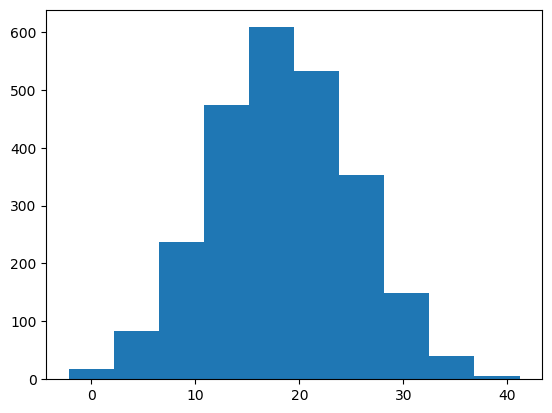

(CLICKSTREAM) THE BOOSTRAPPED ESTIMATED TREATMENT EFFECT FOR 50246_2022_2_2022-02-24_SWITCHING TO IS_6 IS: 18.376928757719732
(CLICKSTREAM) THE BOOSTRAPPED STANDARD ERROR OF THE ESTIMATE FOR 50246_2022_2_2022-02-24_SWITCHING TO IS_6 IS: 6.835552494279979
--- TOTAL RUNTIME OF CLICKSTREAM RDD FOR50246_2022_2IS 31.71188259124756
========== RUNNING CLICKSTREAM RDD FOR 50246_2022_2 ==========
(CLICKSTREAM) FINAL RDD ESTIMATE FOR 50246_2022_2 IS: 18.376928757719732
(CLICKSTREAM) FINAL RDD ESTIMATE STD ERROR FOR 50246_2022_2 IS: 6.835552494279979
(CLICKSTREAM) FINAL Z SCORE FOR 50246_2022_2 IS: 2.688433564528636
(CLICKSTREAM) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 5% FOR 50246_2022_2 IS: True
(CLICKSTREAM) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 10% FOR 50246_2022_2 IS: True
--- TOTAL RUNTIME OF CLICKSTREAM RDD RESULT SUMMARY FOR50246_2022_2IS 0.0001628398895263672
========== GENERATING AS ORDERS DATA SLICE FOR: 50246_2022_2==========
AS ORDERS FOR 50246_2022_2 IS 4248
--- 5.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


==========Converting CP data into Pandas data frame==========
--- 322.87802958488464 seconds ---


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

--- TOTAL --- 59.61443734169006 seconds ---
CP NULL VALUE COUNTS FOR 50246_2022_2_2022-02-11_SWITCHING TO IS_7 IS 0.0
CP_V2 NULL VALUE COUNTS FOR 50246_2022_2_2022-02-11_SWITCHING TO IS_7 IS 0.0
CP_V3 NULL VALUE COUNTS FOR 50246_2022_2_2022-02-11_SWITCHING TO IS_7 IS 0.0
CP_V4 NULL VALUE COUNTS FOR 50246_2022_2_2022-02-11_SWITCHING TO IS_7 IS 0.0
--- TOTAL RUNTIME FOR RDD CONSTRUCTION OF50246_2022_2IS 385.1334240436554
dictionary saved successfully to file
========== RUNNING AS_ORDERS RDD FOR 50246_2022_2 ==========
========== NOW RUNNING JOINT_WEIGHTED REGRESSION ==========
FOR SAMPLE 2022-02-11_SWITCHING TO IS_7, DATA POINTS: 2220
JOINT SAMPLE HAS DATA POINTS: 2220
========== STEP 1: FURTHER FEATURE ENGINEERING: REMOVE NULL DATA POINTS ==========
RESULTING DATA POINTS: 2220
========== STEP 2: FURTHER FEATURE ENGINEERING: ADD NON-LINEARITY==========
NO NEED TO JOIN AND PROCEED AS SEPARATE REGRESSION
========== STEP 3: FURTHER FEATURE ENGINEERING: WINDOW LENGTH ADJUSTMENT==========
RES

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


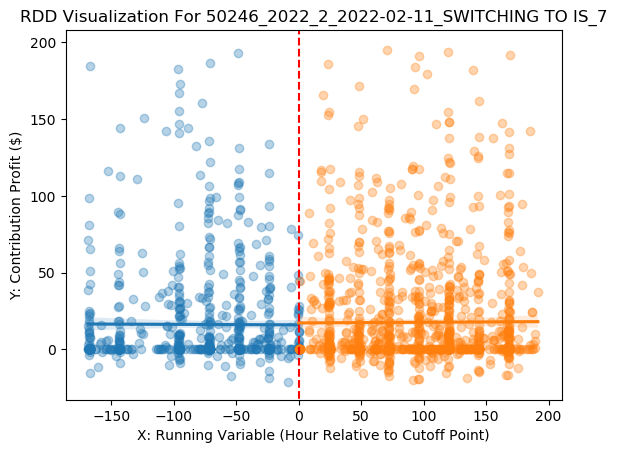

========== STEP 6: REGRESSION==========


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


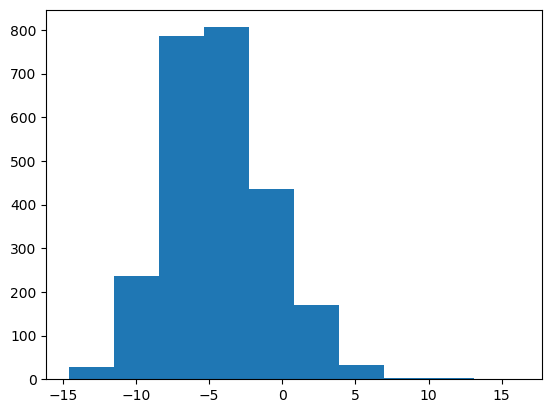

(AS_ORDERS) THE BOOSTRAPPED ESTIMATED TREATMENT EFFECT FOR 50246_2022_2_2022-02-11_SWITCHING TO IS_7 IS: -4.35025905741737
(AS_ORDERS) THE BOOSTRAPPED STANDARD ERROR OF THE ESTIMATE FOR 50246_2022_2_2022-02-11_SWITCHING TO IS_7 IS: 3.532008004322057
--- TOTAL RUNTIME OF AS_ORDERS RDD FOR50246_2022_2IS 12.566579341888428
========== SUMMARIZING AS_ORDERS RDD RESULTS FOR 50246_2022_2 ==========
(AS_ORDERS) FINAL RDD ESTIMATE FOR 50246_2022_2 IS: -4.35025905741737
(AS_ORDERS) FINAL RDD ESTIMATE STD ERROR FOR 50246_2022_2 IS: 3.532008004322057
(AS_ORDERS) FINAL Z SCORE FOR 50246_2022_2 IS: -1.2316673835659582
(AS_ORDERS) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 5% FOR 50246_2022_2 IS: False
(AS_ORDERS) FINAL STATISTICAL SIGNIFICANCE CONFIDENCE LEVEL 10% FOR 50246_2022_2 IS: False
--- TOTAL RUNTIME OF AS_ORDERS RDD RESULT SUMMARY FOR50246_2022_2IS 0.0004627704620361328
==========WORK IS COMPLETED FOR 50246_2022_2 ==========
--- 1606.899757385254 seconds ---
==========WORKING ON INDEX:

Py4JJavaError: An error occurred while calling o8907.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 343.0 failed 1 times, most recent failure: Lost task 15.0 in stage 343.0 (TID 29185) (datascience-1-0-ml-m5-4xlarge-fd25cecfc0563e0c3aa25074f8eb executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.util.Arrays.copyOfRange(Arrays.java:3520)
	at org.apache.parquet.io.api.Binary$ByteArraySliceBackedBinary.getBytes(Binary.java:151)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory$FixedLenByteArrayUpdater.readValue(ParquetVectorUpdaterFactory.java:929)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory$FixedLenByteArrayUpdater.readValues(ParquetVectorUpdaterFactory.java:915)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedRleValuesReader.readBatchInternal(VectorizedRleValuesReader.java:230)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedRleValuesReader.readBatch(VectorizedRleValuesReader.java:171)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedColumnReader.readBatch(VectorizedColumnReader.java:220)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextBatch(VectorizedParquetRecordReader.java:283)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextKeyValue(VectorizedParquetRecordReader.java:181)
	at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:93)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:522)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:87)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:79)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:224)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1481)
	at org.apache.spark.storage.BlockManager$$Lambda$1373/753330705.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1408)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1472)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1295)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:335)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.util.Arrays.copyOfRange(Arrays.java:3520)
	at org.apache.parquet.io.api.Binary$ByteArraySliceBackedBinary.getBytes(Binary.java:151)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory$FixedLenByteArrayUpdater.readValue(ParquetVectorUpdaterFactory.java:929)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetVectorUpdaterFactory$FixedLenByteArrayUpdater.readValues(ParquetVectorUpdaterFactory.java:915)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedRleValuesReader.readBatchInternal(VectorizedRleValuesReader.java:230)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedRleValuesReader.readBatch(VectorizedRleValuesReader.java:171)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedColumnReader.readBatch(VectorizedColumnReader.java:220)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextBatch(VectorizedParquetRecordReader.java:283)
	at org.apache.spark.sql.execution.datasources.parquet.VectorizedParquetRecordReader.nextKeyValue(VectorizedParquetRecordReader.java:181)
	at org.apache.spark.sql.execution.datasources.RecordReaderIterator.hasNext(RecordReaderIterator.scala:39)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:93)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:522)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:759)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:87)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.next(InMemoryRelation.scala:79)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:224)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1481)
	at org.apache.spark.storage.BlockManager$$Lambda$1373/753330705.apply(Unknown Source)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1408)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1472)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1295)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:384)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:335)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)


In [29]:
# 1. CP data
cp_data_path = "s3a://prd-use1-datascientists-sc-fp-data/prd/aero/AERO_ORDER_PLACED_WITH_CP_DATA/"
df_cp = read_cp_data(cp_data_path)

start_time = time.time()
print("========== CP data points: " + str(df_cp.count()) + "==========")
print("--- %s seconds ---" % (time.time() - start_time))

# 2. Complete clickstream data
clickstream_data_path = "s3a://prd-use1-datascientists-sc-fp-data/prd/aero/AERO_CLICK_STREAM_CUSTOMER/"
df_clickstream_data = read_clickstream_data(clickstream_data_path)

start_time = time.time()
print("========== Clickstream data points: " + str(df_clickstream_data.count()) + "==========")
print("--- %s seconds ---" % (time.time() - start_time))

# 3. Complete scheduled as order data
as_orders_data_path = "s3a://prd-use1-datascientists-sc-fp-data/prd/aero/AERO_AS_SALES/"
df_as_orders_data = read_as_orders_data(as_orders_data_path)

start_time = time.time()
print("========== Scheduled as order data points: " + str(df_as_orders_data.count()) + "==========")
print("--- %s seconds ---" % (time.time() - start_time))

# 4. SKU-Month pool
sku_month_data_path = "gv_candidate_sku_months.csv"
pd_sku_month_complete = pd.read_csv(sku_month_data_path)

start_index = 3
end_index = 9
pd_sku_month = pd_sku_month_complete.iloc[start_index:end_index]

start_time = time.time()
print("========== Candidate SKU-Months: " + str(len(pd_sku_month)) + "==========")
print("--- %s seconds ---" % (time.time() - start_time))

# 5. Initialize outputs

non_as_demand_share_collection = {}
as_demand_share_collection = {}

clickstream_non_as_demand_coefficient_collection = {}
as_orders_as_demand_coefficient_collection = {}

clickstream_cutoff_points_collection = {}
as_orders_cutoff_points_collection = {}

clickstream_rdd_sample_collection = {}
clickstream_rdd_estimate_collection = {}
finalized_clickstream_rdd_estimates = {}
as_orders_rdd_sample_collection = {}
as_orders_rdd_estimate_collection = {}
finalized_as_orders_rdd_estimates = {}


# 6. Algorithm 

i = 0

for index, row in pd_sku_month.iterrows():
    
    # timer
    start_time_initial = time.time()
    
    # SKU, Year, Month
    product_part_number_for_sample =  int(row["PRODUCT_PART_NUMBER"])
    year_value_for_sample = int(row["YEAR"])
    month_value_for_sample = int(row["MONTH"])

    first_layer_index = str(product_part_number_for_sample)+ "_" + str(year_value_for_sample) + "_" + str(month_value_for_sample)
    
    print("==========WORKING ON INDEX: " + str(i) + " EXAMPLE NO. " + first_layer_index + " ==========")
    
    # Part 1. Clickstream Portion of Instock Value  
    
    # 1. Clickstream slice
    print("========== GENERATING CLICKSTREAM DATA SLICE FOR: " + first_layer_index + "==========")
    start_time = time.time()
    df_clickstream_data_slice, pd_clickstream_data_slice = clickstream_slice_pandas(df_clickstream_data, product_part_number_for_sample, year_value_for_sample, month_value_for_sample)
    print("CLICKSTREAM COUNTS FOR " + first_layer_index + " IS " + str(len(pd_clickstream_data_slice)))
    print("--- %s seconds ---" % (time.time() - start_time))

    # 2. Two key ingredients for clickstream portion of instock value: non-AS demand share & clickstream counts per unit of non-AS demand
    
    # 2.1. Clickstream Counts
    is_clickstream_counts, oos_clickstream_counts, total_clickstream_counts = clickstream_counts_by_instock_status(pd_clickstream_data_slice)

    print("IS CLICKSTREAM COUNTS FOR " + first_layer_index + " IS " + str(is_clickstream_counts))
    print("OOS CLICKSTREAM COUNTS FOR " + first_layer_index + " IS " + str(oos_clickstream_counts))
    print("TOTAL CLICKSTREAM COUNTS FOR " + first_layer_index + " IS " + str(total_clickstream_counts))

    # 2.2. CP (orders) data
    df_cp_sku_month = df_cp.filter( (F.col("PRODUCT_PART_NUMBER_IN_CP") == str(product_part_number_for_sample)) & \
                            (F.col("ORDER_PLACED_YEAR_CP") == year_value_for_sample) & \
                            (F.col("ORDER_PLACED_MONTH_CP") == month_value_for_sample))

    df_cp_sku_month.persist()

    # 2.3. Units sold by as status
    start_time = time.time()
    non_as_units_sold, as_units_sold, total_units_sold = units_sold_by_as_status(df_cp_sku_month)
    print("NON-AS SOLD UNITS FOR " + first_layer_index + " IS " + str(non_as_units_sold))    
    print("AS SOLD UNITS FOR " + first_layer_index + " IS " + str(as_units_sold))  
    print("TOTAL SOLD UNITS FOR " + first_layer_index + " IS " + str(total_units_sold))  
    print("--- %s seconds ---" % (time.time() - start_time))

    # 2.4. AS & non-AS demand shares
    non_as_share = non_as_units_sold/(non_as_units_sold+as_units_sold)
    as_share =  1 - non_as_share

    print("NON-AS DEMAND SHARE FOR " + first_layer_index + " IS " + str(non_as_share))
    print("AS DEMAND SHARE FOR " + first_layer_index + " IS " + str(as_share))
    
    # 2.5. Coefficients: clickstream counts per unit of non-AS demand
    clickstream_coef = is_clickstream_counts / non_as_units_sold

    print("CLICKSTREAM-NON-AS-DEMAND COEFFICIENT FOR " + first_layer_index + " IS " + str(clickstream_coef))

    # 2.6. save the two key elements: non-AS demand share & clickstream coefficient
    non_as_demand_share_collection[first_layer_index] = non_as_share
    clickstream_non_as_demand_coefficient_collection[first_layer_index] = clickstream_coef
             
    # 3. Clickstream cutoff Date Data
    pd_clickstream_cutoff_point_detection, pd_clickstream_cutoff_points = find_clickstream_cutoff_dates(pd_clickstream_data_slice)
    
    print("THE LIST OF CUTOFF POINT DATES AND STATUSES FOR CLICKSTREAM DATA FOR " + first_layer_index + ":")
    print(pd_clickstream_cutoff_point_detection)
    print(pd_clickstream_cutoff_points)
    # clickstream_cutoff_points_collection[first_layer_index] = pd_clickstream_cutoff_points
    
    # 4. RDD regression sample construction
    sufficiency_ratio = 0.5 
    initial_window_length = 7
    clickstream_rdd_sample_collection[first_layer_index] = construct_clickstream_rdd_samples(pd_clickstream_cutoff_points, pd_clickstream_cutoff_point_detection, pd_clickstream_data_slice, sufficiency_ratio, initial_window_length, first_layer_index, df_cp)
        
    with open('clickstream_rdd_sample_collection_part2.pkl', 'wb') as fp:
        pickle.dump(clickstream_rdd_sample_collection, fp)
        print('dictionary saved successfully to file')

    # with open('clickstream_rdd_sample_collection_part2.pkl', 'rb') as fp:
    #    clickstream_rdd_sample_collection = pickle.load(fp)
    #    print('Reading the RDD samples')
        
    # 5. Regression and Result Summaries
    # CP_V3: CP of ALL products OTHER THAN the one of interest
    cp_variable = "CP_V3"
    
    # Polynomial order of running variable
    K = 1
    # Three types: SEPARATE_UNWEIGHTED (Run RDD for each sample with OLS), SEPARATE_WEIGHTED (Run RDD for each sample with WLS), JOINT_WEIGHTED (Run RDD on a combined sample with WLS)
    regression_type = "JOINT_WEIGHTED"
    # assign higher weights to data points within 24 hours of the cutoff point
    h = 24
    a1 = 1
    a2 = 2
    bootstrapping_method = True
    boostramp_sample_size = 2500
    clickstream_rdd_estimate_collection[first_layer_index] = clickstream_rdd_modeling(clickstream_rdd_sample_collection[first_layer_index], first_layer_index, cp_variable, K, regression_type, h, a1, a2, bootstrapping_method, boostramp_sample_size)
    finalized_clickstream_rdd_estimates[first_layer_index] = clickstream_rdd_result_summary(clickstream_rdd_estimate_collection[first_layer_index], first_layer_index)

    # Part 2. AS Order Portion of Instock Value  
    
    # 1. Scheduled AS orders slice 
    print("========== GENERATING AS ORDERS DATA SLICE FOR: " + first_layer_index + "==========")
    start_time = time.time()
    df_as_orders_data_slice, pd_as_orders_data_slice = as_orders_slice_pandas(df_as_orders_data, product_part_number_for_sample, year_value_for_sample, month_value_for_sample)
    print("AS ORDERS FOR " + first_layer_index + " IS " + str(len(pd_as_orders_data_slice)))
    print("--- %s seconds ---" % (time.time() - start_time))

    # 2. Two key ingredients for as orders portion of instock value: AS demand share & scheduled as orders per unit of AS demand
    
    # 2.1. AS orders 
    is_as_orders_counts, oos_as_orders_counts, total_as_orders_counts = as_orders_by_instock_status(pd_as_orders_data_slice)

    print("IS SCHEDULED AS ORDERS FOR " + first_layer_index + " IS " + str(is_as_orders_counts))
    print("OOS SCHEDULED AS ORDERS FOR " + first_layer_index + " IS " + str(oos_as_orders_counts))
    print("TOTAL SCHEDULED AS ORDERS FOR " + first_layer_index + " IS " + str(total_as_orders_counts))

    # 2.2. AS demand share
    print("AS DEMAND SHARE FOR " + first_layer_index + " IS " + str(as_share))

    # 2.3. Coefficients: Scheduled AS orders per unit of AS demand
    as_orders_coef = is_as_orders_counts / as_units_sold
    print("AS-ORDERS-AS-DEMAND COEFFICIENT FOR " + first_layer_index + " IS " + str(as_orders_coef))

    # 2.4. save the two key elements: non-AS demand share & clickstream coefficient
    as_demand_share_collection[first_layer_index] = as_share
    as_orders_as_demand_coefficient_collection[first_layer_index] = as_orders_coef

    # 3. AS orders cutoff date data
    pd_as_orders_cutoff_point_detection, pd_as_orders_cutoff_points = find_as_orders_cutoff_dates(pd_as_orders_data_slice)
    print("THE LIST OF CUTOFF POINT DATES AND STATUSES FOR AS ORDERS DATA FOR " + first_layer_index + ":")
    print(pd_as_orders_cutoff_point_detection)
    print(pd_as_orders_cutoff_points)
    as_orders_cutoff_points_collection[first_layer_index] = pd_as_orders_cutoff_points

    # 4. RDD regression sample construction
    sufficiency_ratio = 0.5 
    initial_window_length = 7
    as_orders_rdd_sample_collection[first_layer_index] = construct_as_orders_rdd_samples(pd_as_orders_cutoff_points, pd_as_orders_cutoff_point_detection, pd_as_orders_data_slice, sufficiency_ratio, initial_window_length, first_layer_index, df_cp)

    with open('as_orders_rdd_sample_collection_part2.pkl', 'wb') as fp:
        pickle.dump(as_orders_rdd_sample_collection, fp)
        print('dictionary saved successfully to file')
        
    # with open('as_orders_rdd_sample_collection_part2.pkl', 'rb') as fp:
    #    as_orders_rdd_sample_collection = pickle.load(fp)
    #    print('Reading the RDD samples')
    
    # 5. Regression and Result Summaries
    cp_variable = "CP_V3"
    K = 1
    regression_type = "JOINT_WEIGHTED"
    h = 24
    a1 = 1
    a2 = 2
    bootstrapping_method = True
    boostramp_sample_size = 2500
    as_orders_rdd_estimate_collection[first_layer_index] = as_orders_rdd_modeling(as_orders_rdd_sample_collection[first_layer_index], first_layer_index, cp_variable, K, regression_type, h, a1, a2, bootstrapping_method, boostramp_sample_size)
    finalized_as_orders_rdd_estimates[first_layer_index] = as_orders_rdd_result_summary(as_orders_rdd_estimate_collection[first_layer_index], first_layer_index)
    
    print("==========WORK IS COMPLETED FOR " + first_layer_index + " ==========")
    print("--- %s seconds ---" % (time.time() - start_time_initial))
    
    i = i+1